In [1]:
# from pybaseball import playerid_reverse_lookup, player_search_list
from helper import _add_deltas, split_name, calc_fantasy_points_batting, calc_fantasy_points_pitching, get_value_before_comma
from read_data import add_era_bucket, add_history_coverage, cast_feature_dtypes, pull_data, pull_projections
from modeling import calculate_productivity_score, add_per_year_features, calculate_years_since_peak, add_player_tier, add_pitcher_role_flags, split_data, create_baseline, tune_xgb, create_model, compile_predictions, combine_projections
from data_viz import plot_actual_vs_pred_mlb, plot_resid_vs_pred_mlb, plot_resid_hist_mlb, plot_decile_calib
from clean_and_cluster import assign_position_group, calculate_relative_value, determine_optimal_k, segment_players
from config import batting_stat_cols, pitching_stat_cols, batting_career_cols, pitching_career_cols, POS_DAMPENING_MAP
from hyperopt import hp
from xgboost import plot_importance
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

START_YEAR = 2005 # <- Beginning season for data pull
END_YEAR = 2025 # <- Ending season for data pull, final model will predict following season
AGG_YEARS = 3
MODEL_WEIGHT = 0.65
PROJECTION_WEIGHT = 1 - MODEL_WEIGHT
ROSTER_SIZE = 20
LEAGUE_SIZE = 12
BONUS_PLAYER_POOL_MULT = 1.15
PITCHER_SPLIT = 0.33
BATTER_SPLIT_IF = 0.33
BATTER_SPLIT_OF = 0.32

# URL of the FantasyPros projections page
batting_url = "https://www.fantasypros.com/mlb/projections/hitters.php"
pitching_url = "https://www.fantasypros.com/mlb/projections/pitchers.php"

C:\Users\jorda\Documents\development\baseball_modeling\.venv\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Pull data for batters & pitchers
batting_df, pitching_df = pull_data(
    start_year=START_YEAR,
    end_year=END_YEAR,
    agg_years=AGG_YEARS,
    batting_stat_cols=batting_stat_cols,
    pitching_stat_cols=pitching_stat_cols,
    batting_career_cols=batting_career_cols,
    pitching_career_cols=pitching_career_cols,
    career_window_years=10, # NOTE: as of 2025, career aggregates can only reach back 10 years in a single pull - rule in pybaseball
)

# Additional feature engineering
# Calculate deltas for core stats over the aggregation window
# Calculate player productivity score (how effective are they relative to their age)
# Ensure proper data types for modeling
batting_df = (
    batting_df
    .pipe(_add_deltas, agg_years=AGG_YEARS, core_cols=batting_career_cols)
    .pipe(calculate_productivity_score, agg_years=AGG_YEARS)
    .pipe(calculate_years_since_peak)
    .pipe(add_era_bucket)
    .pipe(add_history_coverage, agg_years=AGG_YEARS)
    .pipe(add_per_year_features, agg_years=AGG_YEARS, sum_cols=["G", "AB", "R", "H", "HR", "SB", "BB", "SO"],)
    .pipe(add_player_tier, agg_years=AGG_YEARS)
    .pipe(cast_feature_dtypes)
)
pitching_df = (
    pitching_df
    .pipe(_add_deltas, agg_years=AGG_YEARS, core_cols=pitching_career_cols)
    .pipe(calculate_productivity_score, agg_years=AGG_YEARS)
    .pipe(calculate_years_since_peak)
    .pipe(add_pitcher_role_flags)
    .pipe(add_era_bucket)
    .pipe(add_history_coverage, agg_years=AGG_YEARS)
    .pipe(add_per_year_features, agg_years=AGG_YEARS, sum_cols=["G", "GS", "IP", "W", "SO", "BB", "HR", "ER"],)
    .pipe(add_player_tier, agg_years=AGG_YEARS)
    .pipe(cast_feature_dtypes)
)

# Filtering pitchers from batting_df, they should not be included in the batter model
batting_df = batting_df[batting_df["pos_type"] != "Pitcher"].copy()
# Dropping pos_type and primary_pos from pitching_df as they are redundant (every player is a pitcher)
pitching_df = pitching_df.drop(columns=["pos_type", "primary_pos"]).copy()

# Defining the prediction data for batters & pitchers
batting_pred = batting_df[batting_df["Season"] == END_YEAR].copy()
pitching_pred = pitching_df[pitching_df["Season"] == END_YEAR].copy()
# Dropping the prediction year from the training data
batting_df = batting_df[batting_df["Season"] < END_YEAR].copy()
pitching_df = pitching_df[pitching_df["Season"] < END_YEAR].copy()

# Filter out players with negative future fantasy points (will not be fantasy draft eligible regardless)
batting_df = batting_df[batting_df["fantasy_points_future"] > 0].copy()
pitching_df = pitching_df[pitching_df["fantasy_points_future"] > 0].copy()

C:\Users\jorda\Documents\development\baseball_modeling\read_data.py:583: DtypeWarning: Columns (180) have mixed types. Specify dtype option on import or set low_memory=False.


Loaded existing data files.


C:\Users\jorda\Documents\development\baseball_modeling\modeling.py:134: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
C:\Users\jorda\Documents\development\baseball_modeling\modeling.py:134: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


# Pulling FantasyPros Projection Data

In [3]:
batting_projections = pull_projections(batting_url)
# Replace NaN values in the "Positions" column with "DH" for hitters
batting_projections['Positions'] = batting_projections['Positions'].fillna('DH')
# Calculating projected number of singles
batting_projections['1B'] = batting_projections['H'] - batting_projections['2B'] - batting_projections['3B'] - batting_projections['HR']
# Each player will receive 6 projected HBP by default (average number of HBP per season for batters with at least 100 games played)
batting_projections['HBP'] = 6
# Calculating batting fantasy point projection
batting_projections = calc_fantasy_points_batting(batting_projections, 'projected_fantasy_points')
# Selecting relevant columns
batting_projections = batting_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

pitching_projections = pull_projections(pitching_url)
# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_projections['Positions'] = pitching_projections['Positions'].fillna('SP')
# Renaming the "K" column to "SO" for pitchers
pitching_projections = pitching_projections.rename(columns={'K': 'SO'})
# Calculating pitching fantasy point projection
pitching_projections = calc_fantasy_points_pitching(pitching_projections, 'projected_fantasy_points')
# Selecting relevant columns
pitching_projections = pitching_projections[['first_name', 'last_name', 'Team', 'Positions', 'projected_fantasy_points']]

In [4]:
display(batting_projections.head())

first_name last_name Team    Positions  projected_fantasy_points
0     shohei    ohtani  LAD        SP,DH                      1765
1      aaron     judge  NYY  LF,CF,RF,DH                      1721
2      bobby      witt   KC           SS                      1537
3       juan      soto  NYM        LF,RF                      1643
4     ronald     acuna  ATL           RF                      1531

# Defining Baseline Model

## Creating baseline batting predictions

In [5]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(batting_df)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 272.890 | MAE: 212.875 | R^2: 0.623


In [6]:
batting_comp = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_comp)

Name  fantasy_points_future  predicted_fantasy_points  \
116          Juan Soto                 1814.0               1736.483887   
1436   Freddie Freeman                 1845.0               1703.722290   
1052    Hanley Ramirez                 1806.0               1702.192383   
229      Travis Hafner                 1567.0               1682.819702   
739     Miguel Cabrera                 1762.0               1677.418945   
...                ...                    ...                       ...   
1561      Henry Blanco                  207.0                116.600204   
459   John Ryan Murphy                   64.0                111.757088   
553        Roman Quinn                  208.0                110.144905   
551    Grayson Greiner                   89.0                105.705093   
744   Michael Martinez                  132.0                 88.105171   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
116        -77.516113      77.516113    2024   25            1799  
1436      -141.277710     141.277710    2022   32            1648  
1052      -103.807617     103.807617    2006   22            1607  
229        115.819702     115.819702    2005   28            1469  
739        -84.581055      84.581055    2011   28            1718  
...               ...            ...     ...  ...             ...  
1561       -90.399796      90.399796    2007   35              56  
459         47.757088      47.757088    2019   28             120  
553        -97.855095      97.855095    2019   26             240  
551         16.705093      16.705093    2019   26             297  
744        -43.894829      43.894829    2011   28             333  

[1590 rows x 8 columns]

# Building Final Model

In [ ]:
MAX_DEPTH_CHOICES = [4, 5, 6, 7]

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.025), np.log(0.2)),
    "max_depth": hp.choice("max_depth", MAX_DEPTH_CHOICES),
    "subsample": hp.uniform("subsample", 0.7, 1.00),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.7, 1.0),

    "min_child_weight": hp.loguniform("min_child_weight", np.log(1.0), np.log(12.0)),
    "reg_lambda": hp.loguniform("reg_lambda", np.log(0.5), np.log(10.0)),
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-3), np.log(3.0)),
    "gamma": hp.loguniform("gamma", np.log(1e-3), np.log(2.0)),
}

# Batting Predictions

In [8]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(batting_df)

# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=80,
    random_state=4202020,
    id_cols=["IDfg"],
    max_depth_choices=MAX_DEPTH_CHOICES,
)

100%|██████████| 80/80 [02:16<00:00,  1.70s/trial, best loss: 263.03944714279555]
Best Parameters: {'learning_rate': 0.06425060761228046, 'max_depth': 5, 'subsample': 0.9027197081867674, 'colsample_bytree': 0.896378939068407, 'min_child_weight': 2.2933128667552594, 'reg_lambda': 1.0848256253382862, 'reg_alpha': 0.014226157181485486, 'gamma': 0.0010139534726035522}
[Best trial @ val] optimized=rmse | RMSE=263.039 | MAE=201.691 | ASYM=86744.303


In [9]:
# Create final model
batting_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=4202020,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 92
[Val] RMSE: 263.039 | MAE: 201.691 | R^2: 0.617 | ASYM: 86744.303
[Test] RMSE: 270.054 | MAE: 210.614 | R^2: 0.631 | ASYM: 89303.136


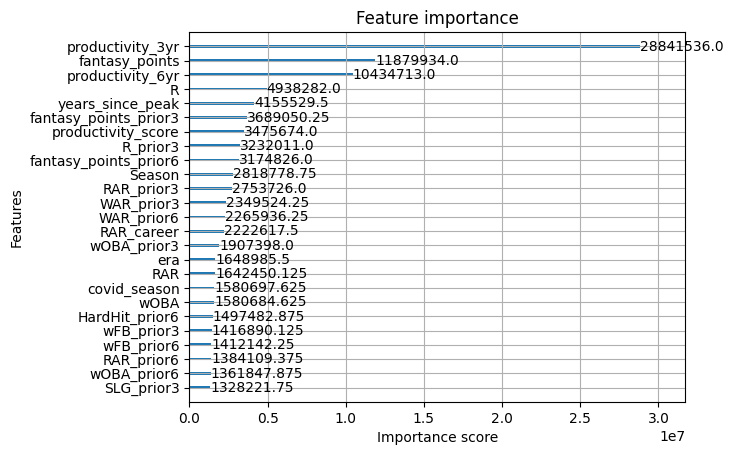

In [10]:
# Plot feature importance using XGBoost's built-in method
plot_importance(batting_model, importance_type="gain", max_num_features=25)
plt.show()

In [11]:
batting_results = compile_predictions(batting_df, x_test, y_test, y_pred)
display(batting_results)

Name  fantasy_points_future  predicted_fantasy_points  \
624      Shohei Ohtani                 2143.0               1751.078613   
739     Miguel Cabrera                 1762.0               1721.921753   
1436   Freddie Freeman                 1845.0               1714.677246   
116          Juan Soto                 1814.0               1681.372681   
279        Chase Utley                 1730.0               1645.801025   
...                ...                    ...                       ...   
744   Michael Martinez                  132.0                124.149948   
603        Jeff Mathis                  108.0                122.555191   
459   John Ryan Murphy                   64.0                121.440331   
551    Grayson Greiner                   89.0                 93.629288   
553        Roman Quinn                  208.0                 91.828468   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
624       -391.921387     391.921387    2023   28            1635  
739        -40.078247      40.078247    2011   28            1718  
1436      -130.322754     130.322754    2022   32            1648  
116       -132.627319     132.627319    2024   25            1799  
279        -84.198975      84.198975    2005   26            1511  
...               ...            ...     ...  ...             ...  
744         -7.850052       7.850052    2011   28             333  
603         14.555191      14.555191    2019   36             256  
459         57.440331      57.440331    2019   28             120  
551          4.629288       4.629288    2019   26             297  
553       -116.171532     116.171532    2019   26             240  

[1590 rows x 8 columns]

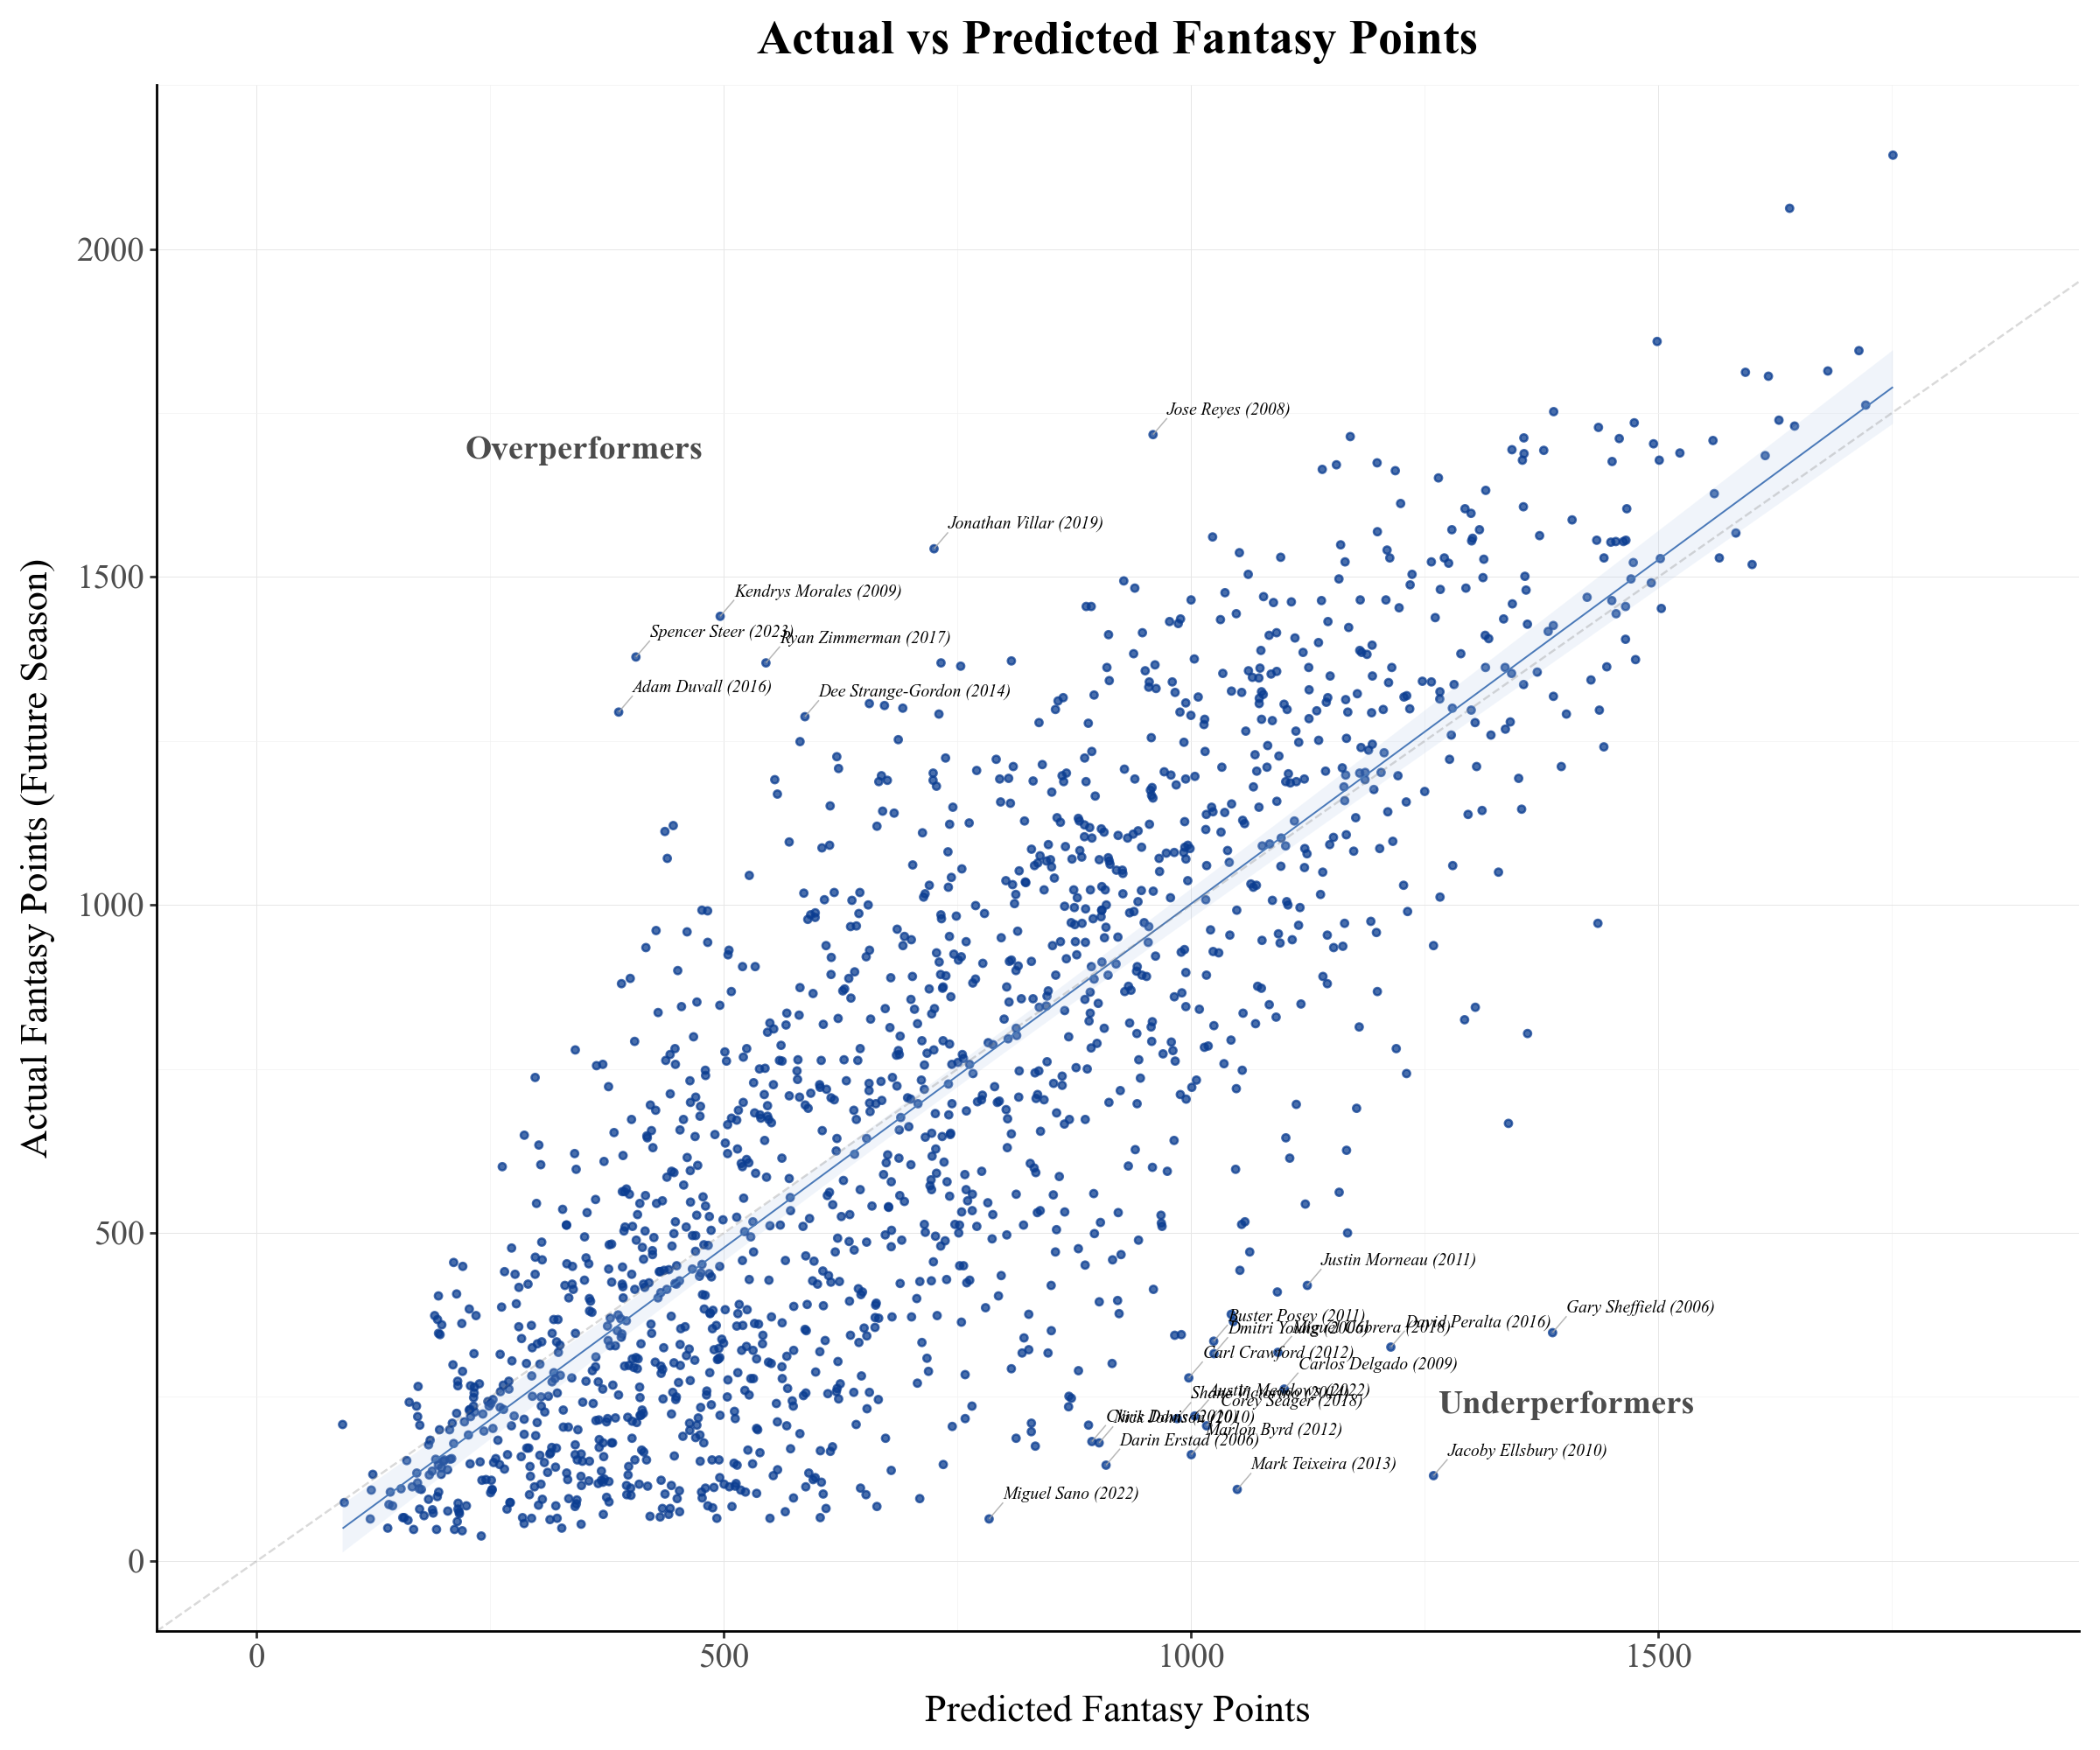

In [12]:
p1 = plot_actual_vs_pred_mlb(
    batting_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

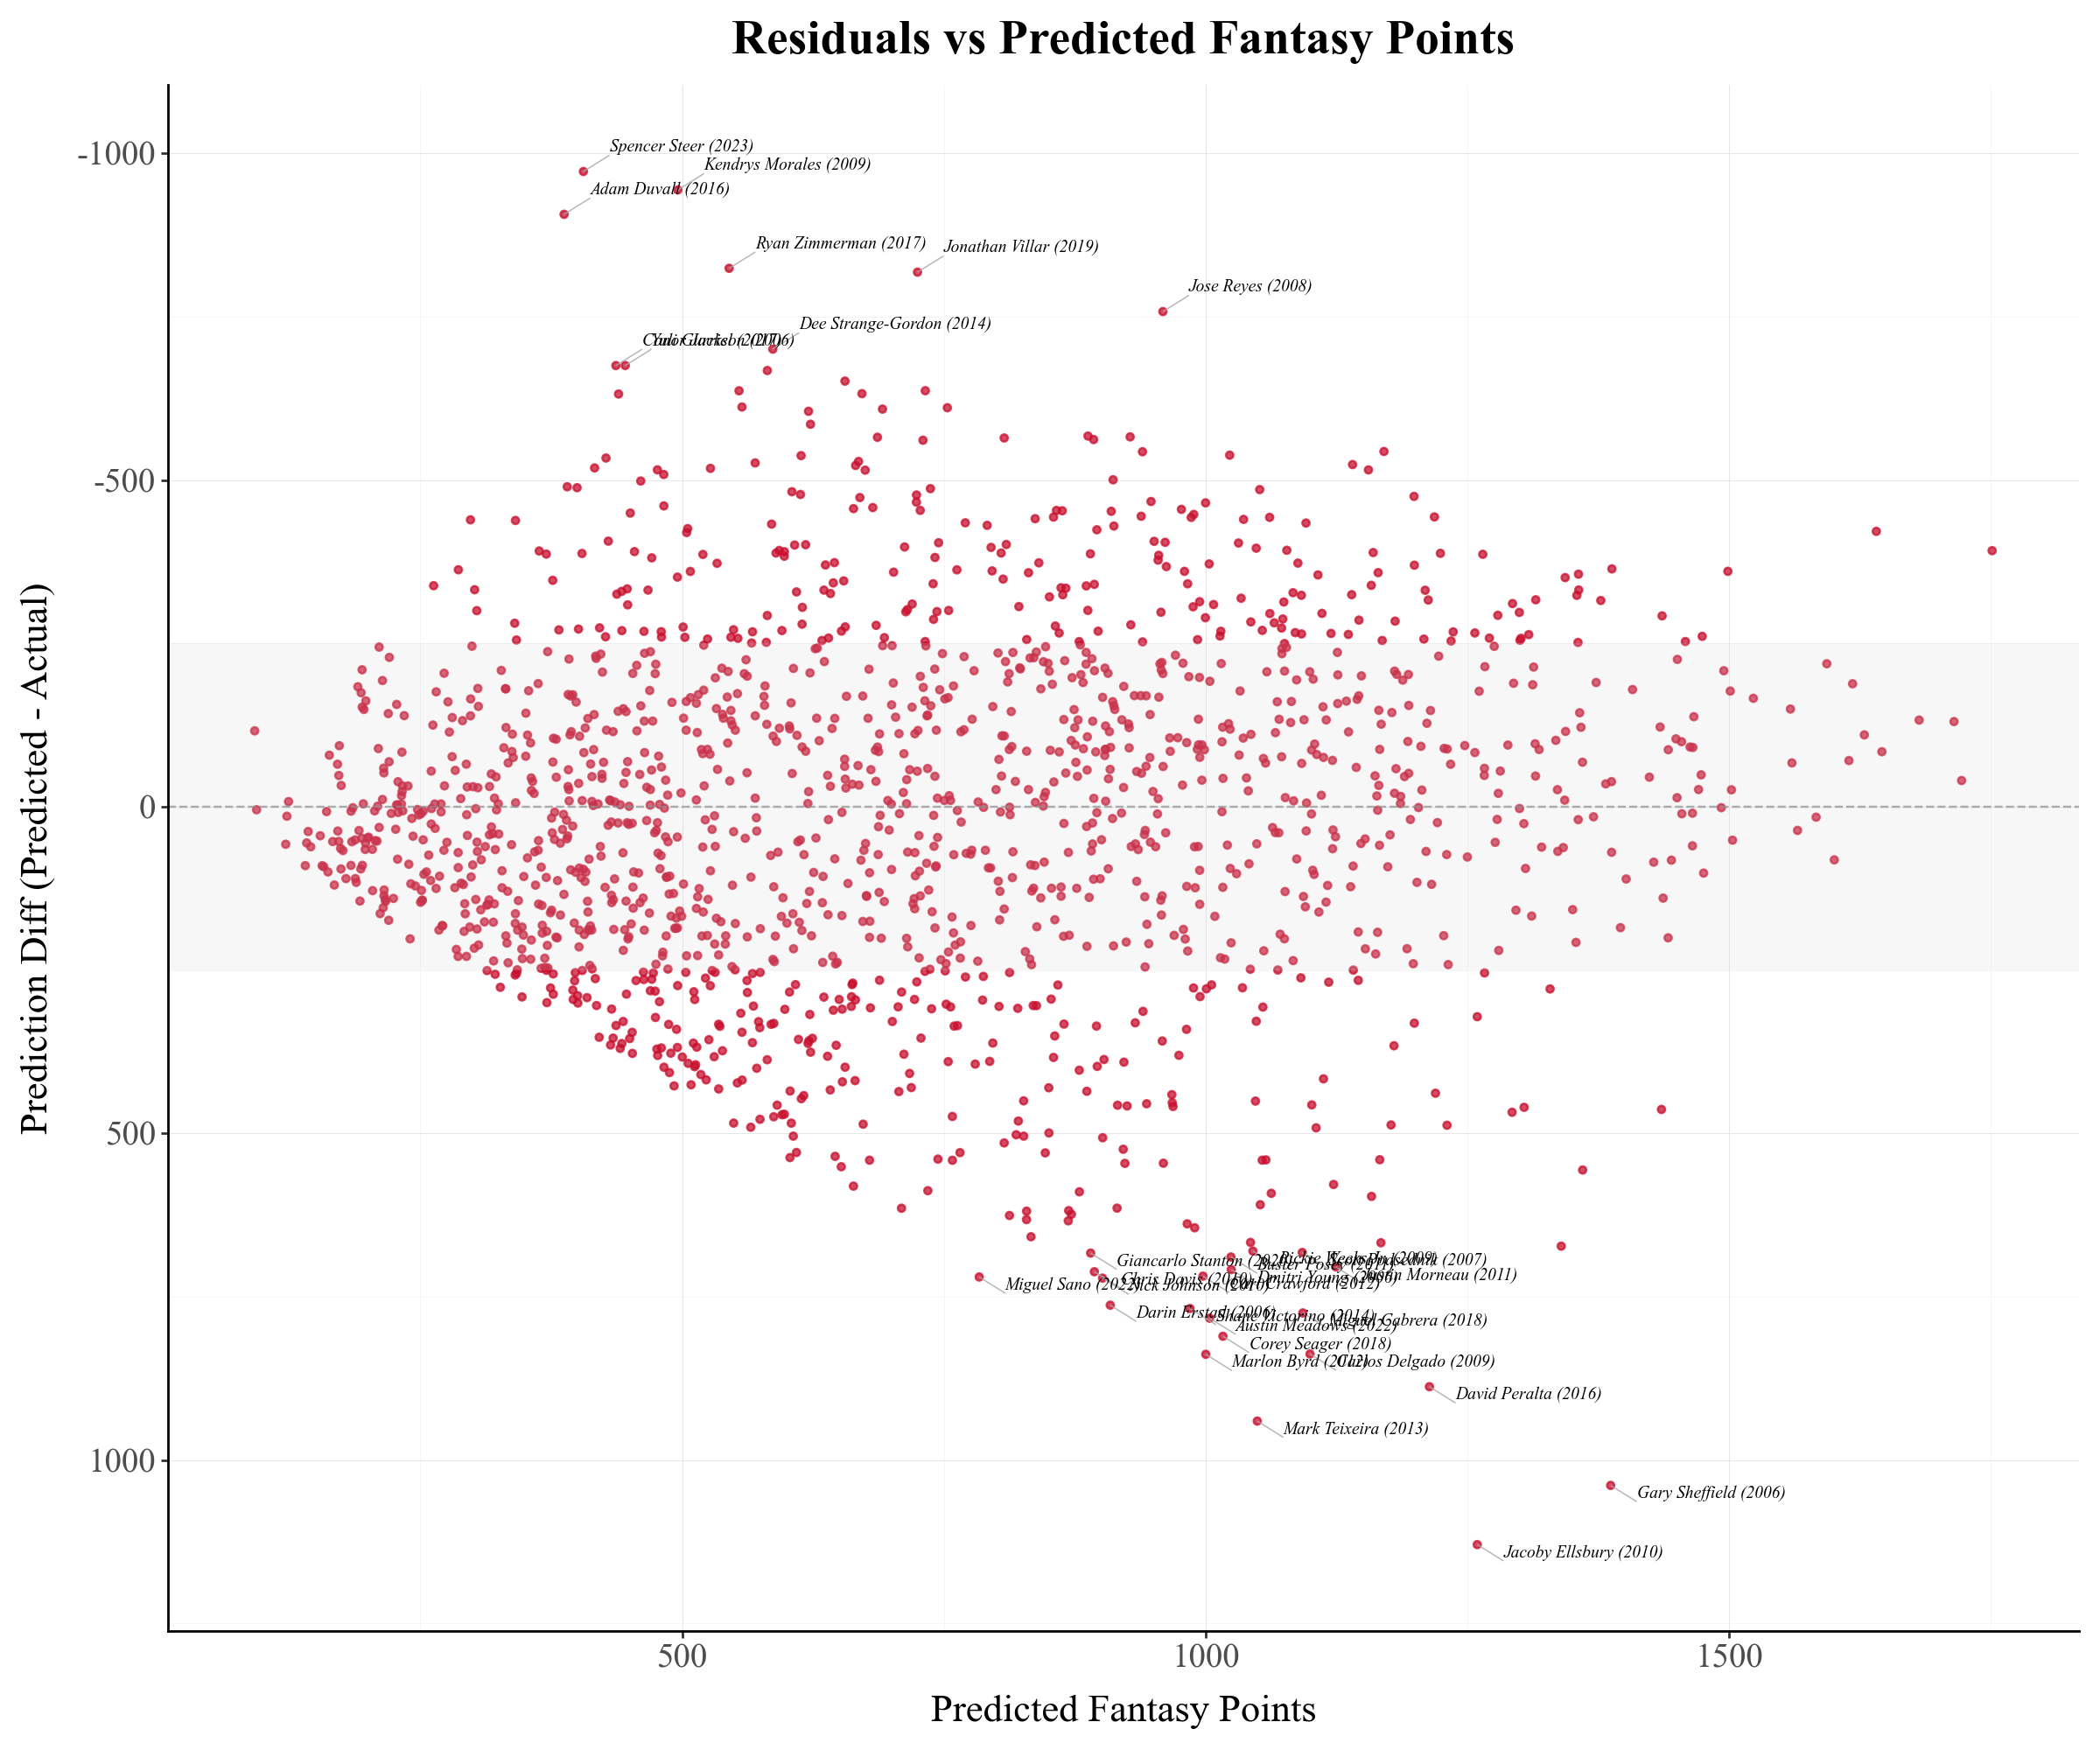

In [13]:
p2 = plot_resid_vs_pred_mlb(
    batting_results,
    band=250,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

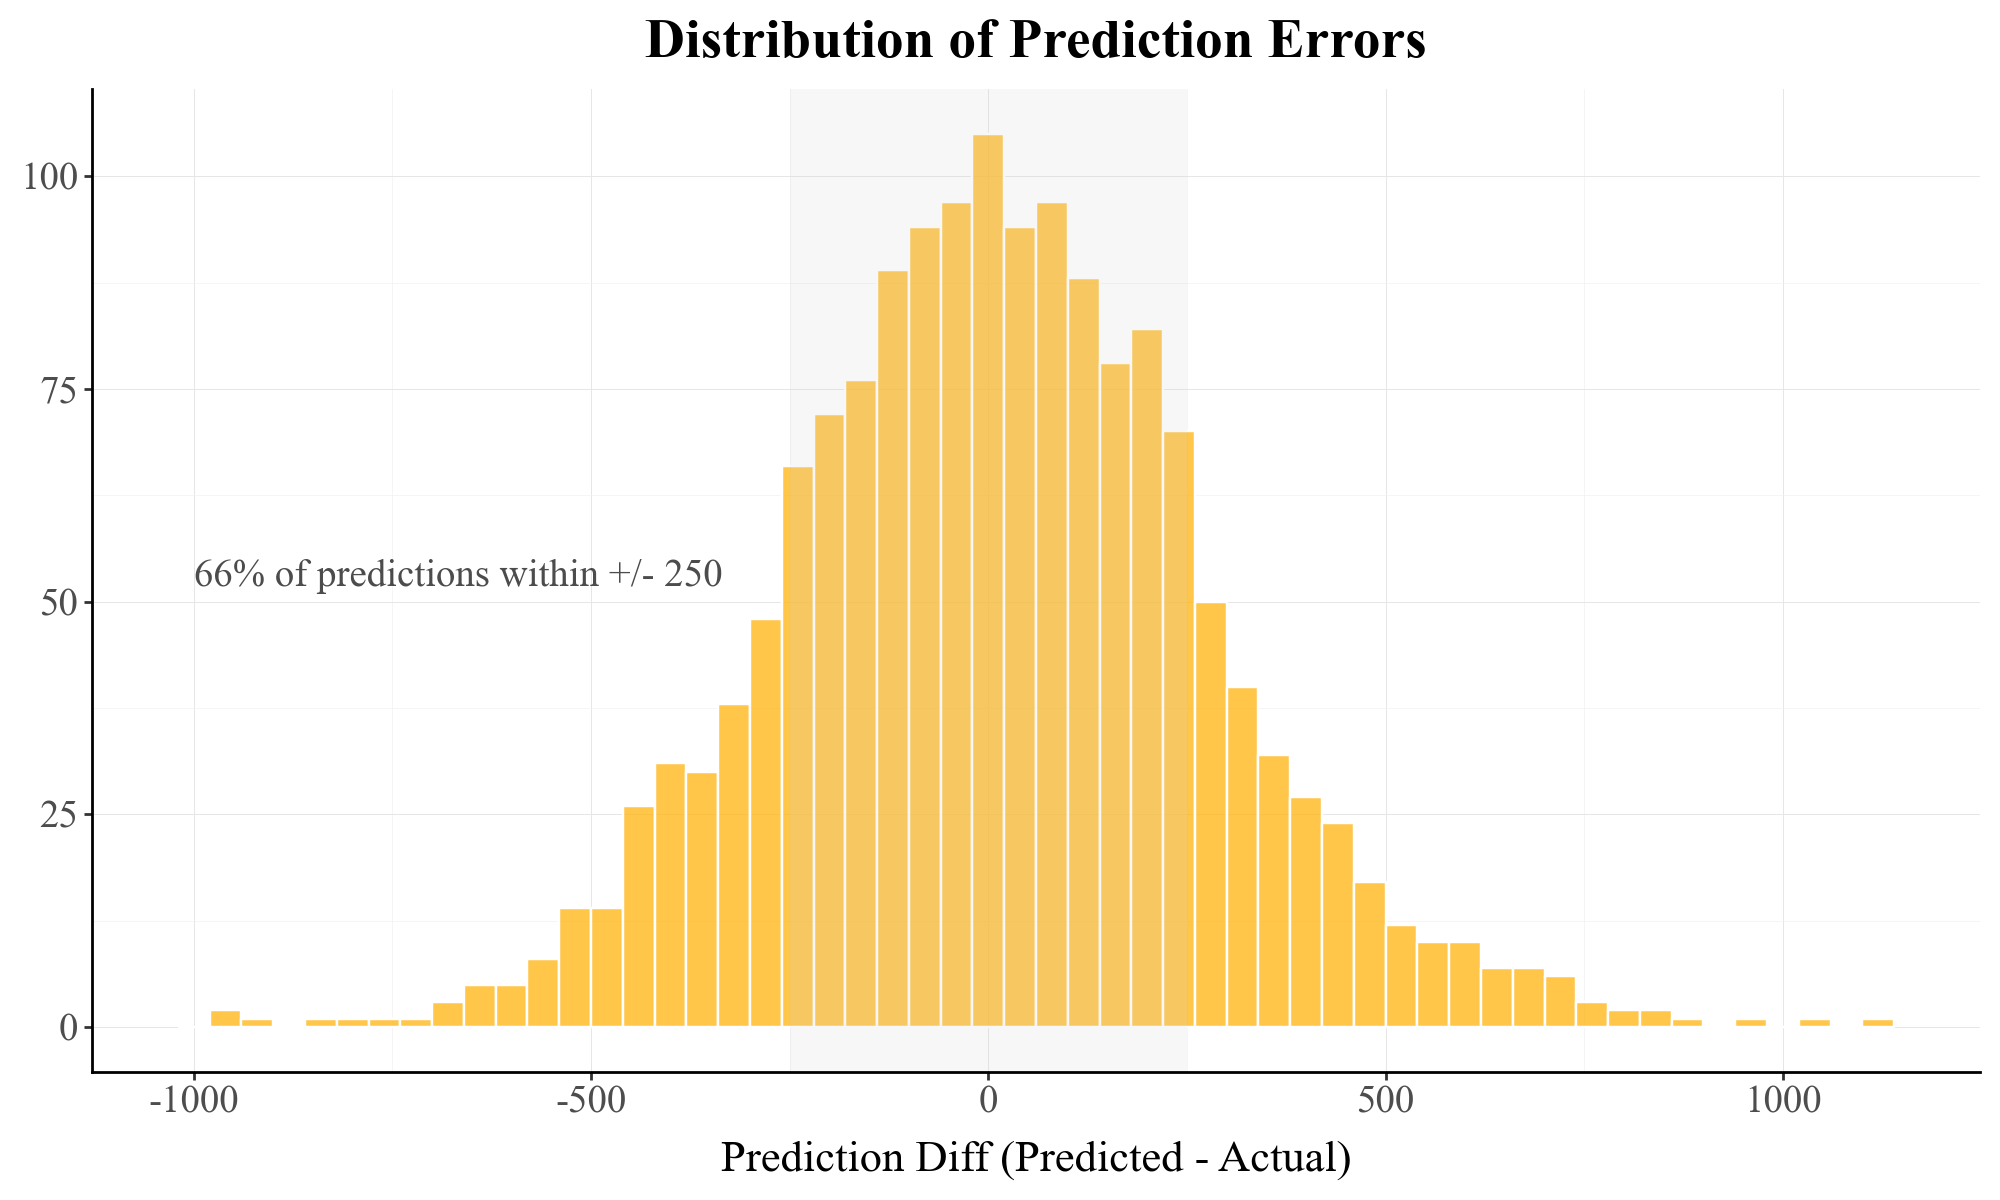

In [14]:
p3 = plot_resid_hist_mlb(
    batting_results,
    band=250,
    binwidth=40,
    x_annotate=-1000,    # custom annotation position
    y_annotate=55,      # custom annotation position
)
p3.show()

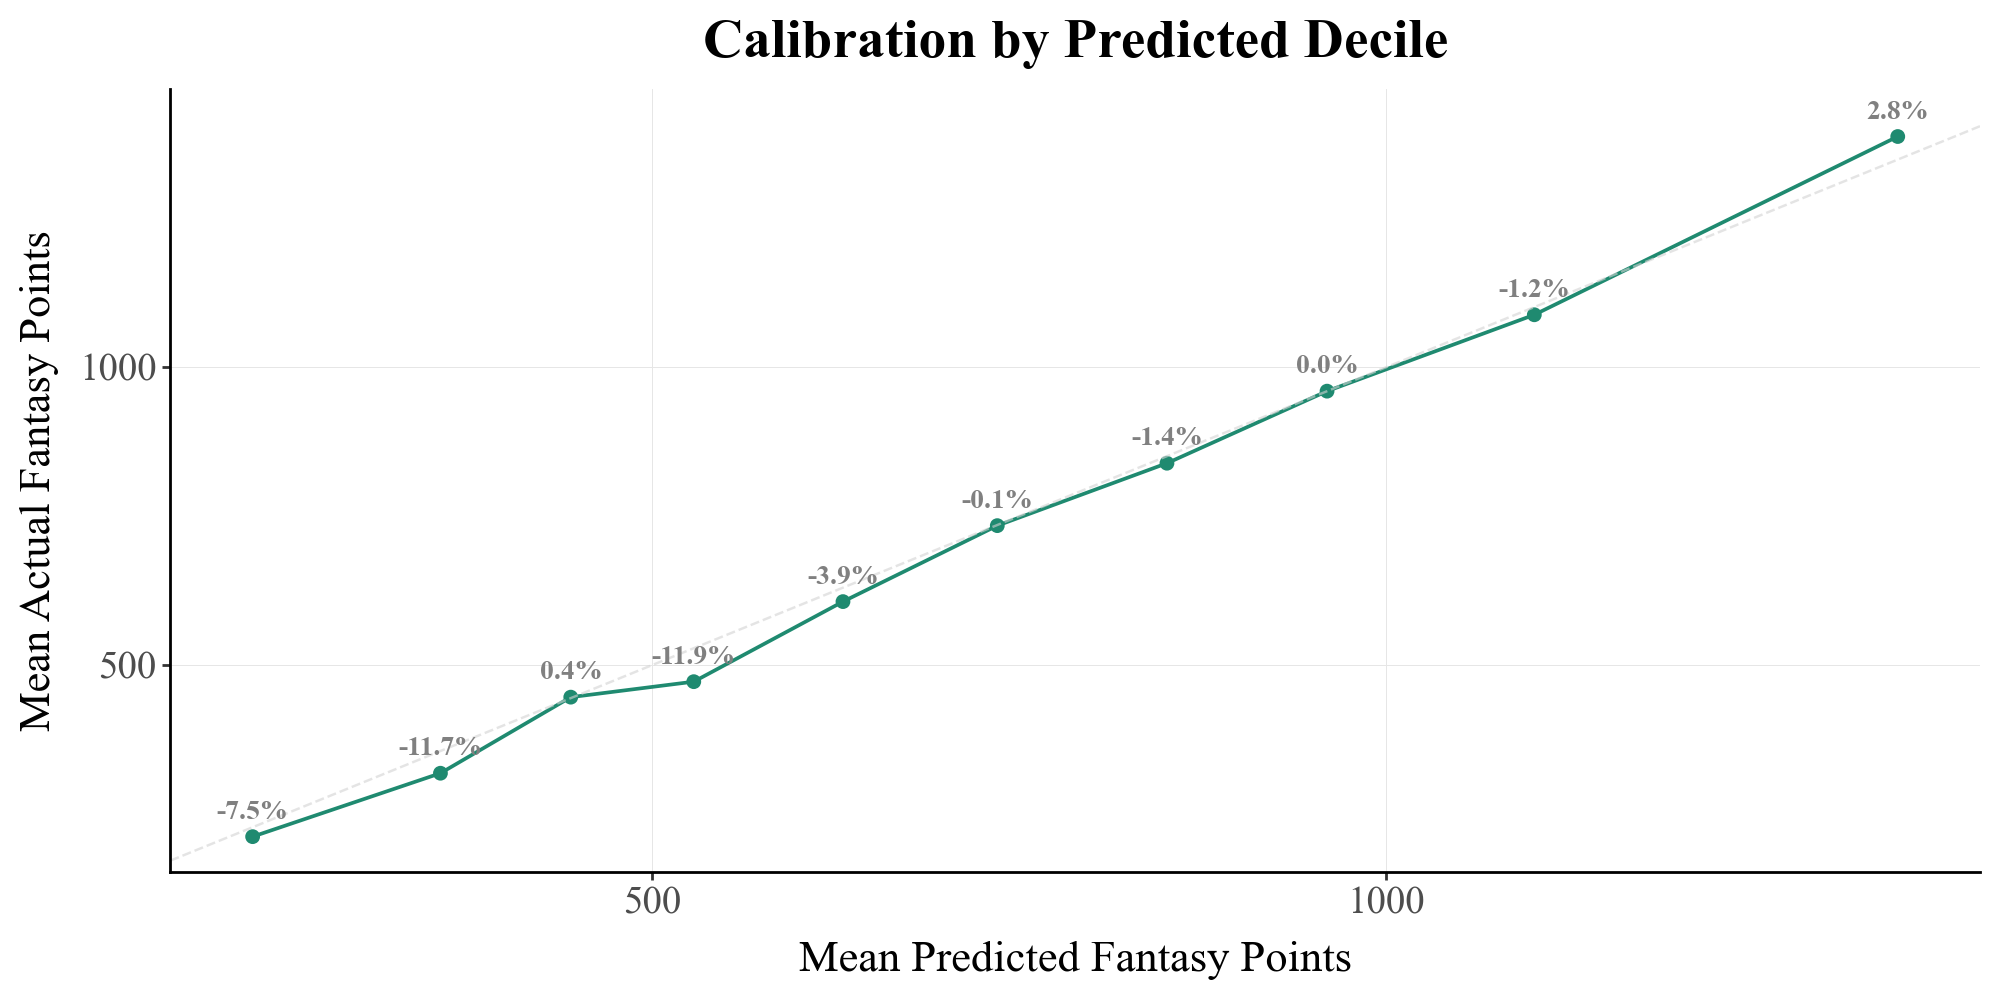

In [15]:
p4 = plot_decile_calib(batting_results)
p4.show()

# Creating baseline pitching predictions

In [16]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(pitching_df)

# Plotting data
model, y_pred = create_baseline(x_train.drop(columns=['IDfg']), x_val.drop(columns=['IDfg']), x_test.drop(columns=['IDfg']), 
                                            y_train, y_val, y_test)

[Test] RMSE: 172.276 | MAE: 126.871 | R^2: 0.627


In [17]:
pitching_comp = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_comp)

Name  fantasy_points_future  predicted_fantasy_points  \
1124        Chris Sale                 1444.3               1344.697998   
347          Cliff Lee                 1309.6               1269.641602   
92    Justin Verlander                 1482.0               1238.085571   
361   Justin Verlander                 1167.3               1192.860718   
313    Felix Hernandez                 1193.0               1175.190063   
...                ...                    ...                       ...   
392        Koda Glover                   62.3                 74.612732   
240       Lewis Thorpe                   39.3                 73.120613   
1187     Cesar Jimenez                   63.0                 68.331261   
553       Lewis Thorpe                   45.3                 65.911407   
44     Stefan Crichton                  136.0                 60.924118   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
1124       -99.602002      99.602002    2016   27          1210.6  
347        -39.958398      39.958398    2010   31          1026.3  
92        -243.914429     243.914429    2018   35          1412.0  
361         25.560718      25.560718    2009   26          1346.0  
313        -17.809937      17.809937    2011   25          1165.6  
...               ...            ...     ...  ...             ...  
392         12.312732      12.312732    2017   24            75.3  
240         33.820613      33.820613    2020   24            45.3  
1187         5.331261       5.331261    2013   28            68.0  
553         20.611407      20.611407    2019   23           132.6  
44         -75.075882      75.075882    2019   27           158.3  

[1525 rows x 8 columns]

# Pitching Predictions

In [18]:
# Splitting data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(pitching_df)

# Tune model
best_params = tune_xgb(
    X_train=x_train,
    X_val=x_val,
    y_train=y_train,
    y_val=y_val,
    space=space,
    metric="rmse",     
    alpha=1.5,
    evals=75,
    random_state=4202020,
    id_cols=["IDfg"],
    max_depth_choices=MAX_DEPTH_CHOICES,
)

100%|██████████| 75/75 [02:32<00:00,  2.04s/trial, best loss: 162.31924005555445]
Best Parameters: {'learning_rate': 0.10698316619834151, 'max_depth': 4, 'subsample': 0.7549449840998662, 'colsample_bytree': 0.9030592446556608, 'min_child_weight': 1.8396937648005165, 'reg_lambda': 7.506161501262269, 'reg_alpha': 0.931204494781253, 'gamma': 0.00648386598872735}
[Best trial @ val] optimized=rmse | RMSE=162.319 | MAE=121.698 | ASYM=32594.742


In [19]:
# Create final model
pitching_model, y_pred = create_model(
    X_train=x_train,
    X_val=x_val,
    X_test=x_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    final_params=best_params,
    random_state=4202020,
    id_cols=["IDfg"],
    alpha=1.5,               
)

Best iteration: 150
[Val] RMSE: 162.319 | MAE: 121.698 | R^2: 0.680 | ASYM: 32594.742
[Test] RMSE: 172.792 | MAE: 127.451 | R^2: 0.625 | ASYM: 37149.851


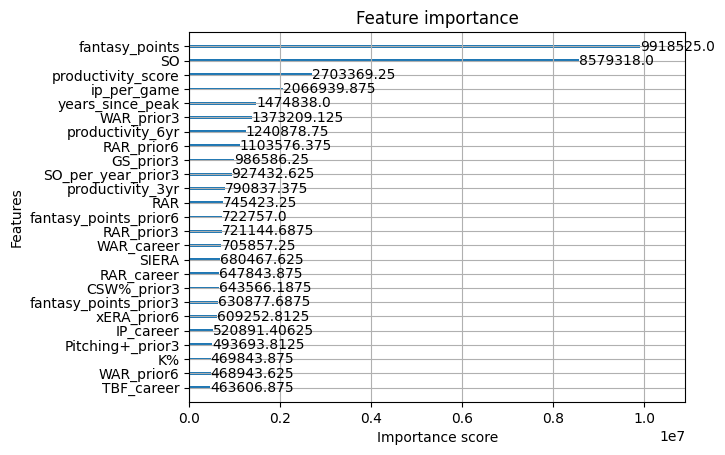

In [20]:
# Plot feature importance using XGBoost's built-in method
plot_importance(pitching_model, importance_type="gain", max_num_features=25)
plt.show()

In [21]:
pitching_results = compile_predictions(pitching_df, x_test, y_test, y_pred)
display(pitching_results)

Name  fantasy_points_future  predicted_fantasy_points  \
361   Justin Verlander                 1167.3               1258.018311   
92    Justin Verlander                 1482.0               1220.320190   
96     Clayton Kershaw                 1514.6               1196.635498   
313    Felix Hernandez                 1193.0               1191.713013   
1124        Chris Sale                 1444.3               1182.413818   
...                ...                    ...                       ...   
445    Eduardo Paredes                   57.3                 64.912209   
1381      Adam Kolarek                  105.0                 63.845276   
240       Lewis Thorpe                   39.3                 63.127213   
1072   Ryan Feierabend                   98.6                 42.644073   
44     Stefan Crichton                  136.0                 31.558523   

      prediction_diff  absolute_diff  Season  Age  fantasy_points  
361         90.718311      90.718311    2009   26          1346.0  
92        -261.679810     261.679810    2018   35          1412.0  
96        -317.964502     317.964502    2014   26          1299.3  
313         -1.286987       1.286987    2011   25          1165.6  
1124      -261.886182     261.886182    2016   27          1210.6  
...               ...            ...     ...  ...             ...  
445          7.612209       7.612209    2017   22            84.3  
1381       -41.154724      41.154724    2019   30           270.0  
240         23.827213      23.827213    2020   24            45.3  
1072       -55.955927      55.955927    2007   21           101.3  
44        -104.441477     104.441477    2019   27           158.3  

[1525 rows x 8 columns]

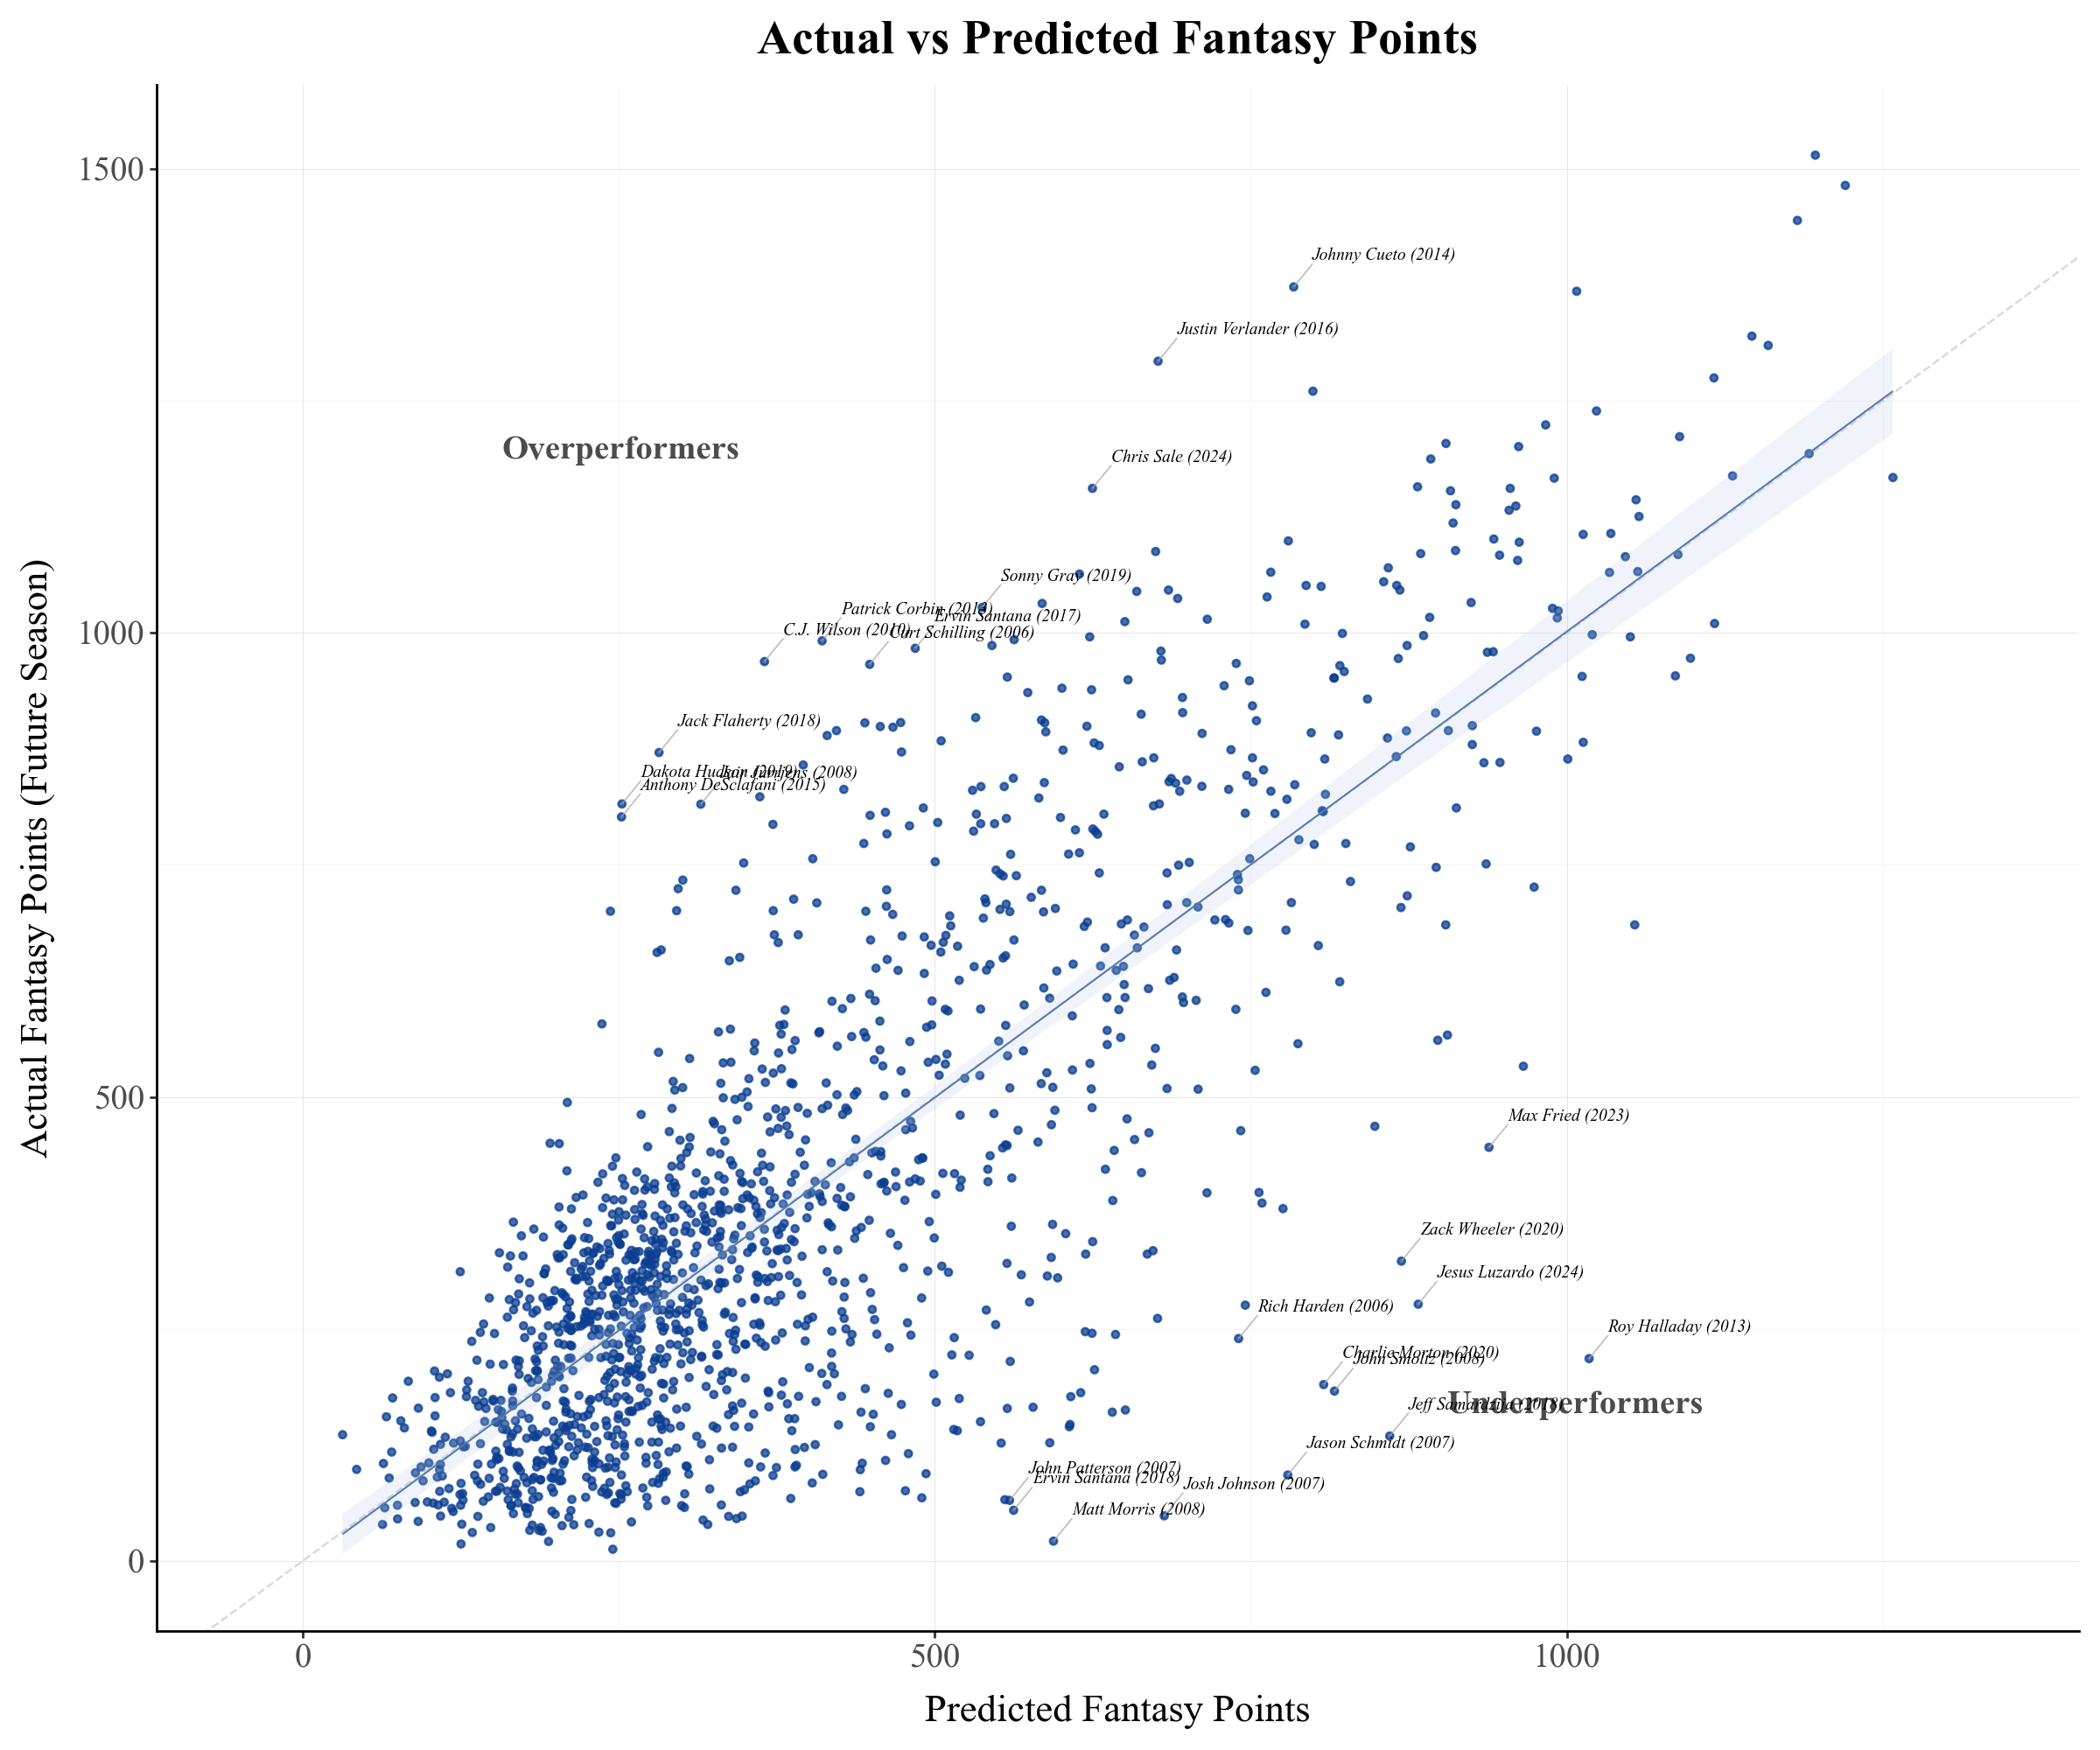

In [22]:
p1 = plot_actual_vs_pred_mlb(
    pitching_results,
    top_n=25,
    x_offset=15,
    y_offset=25,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p1.show()

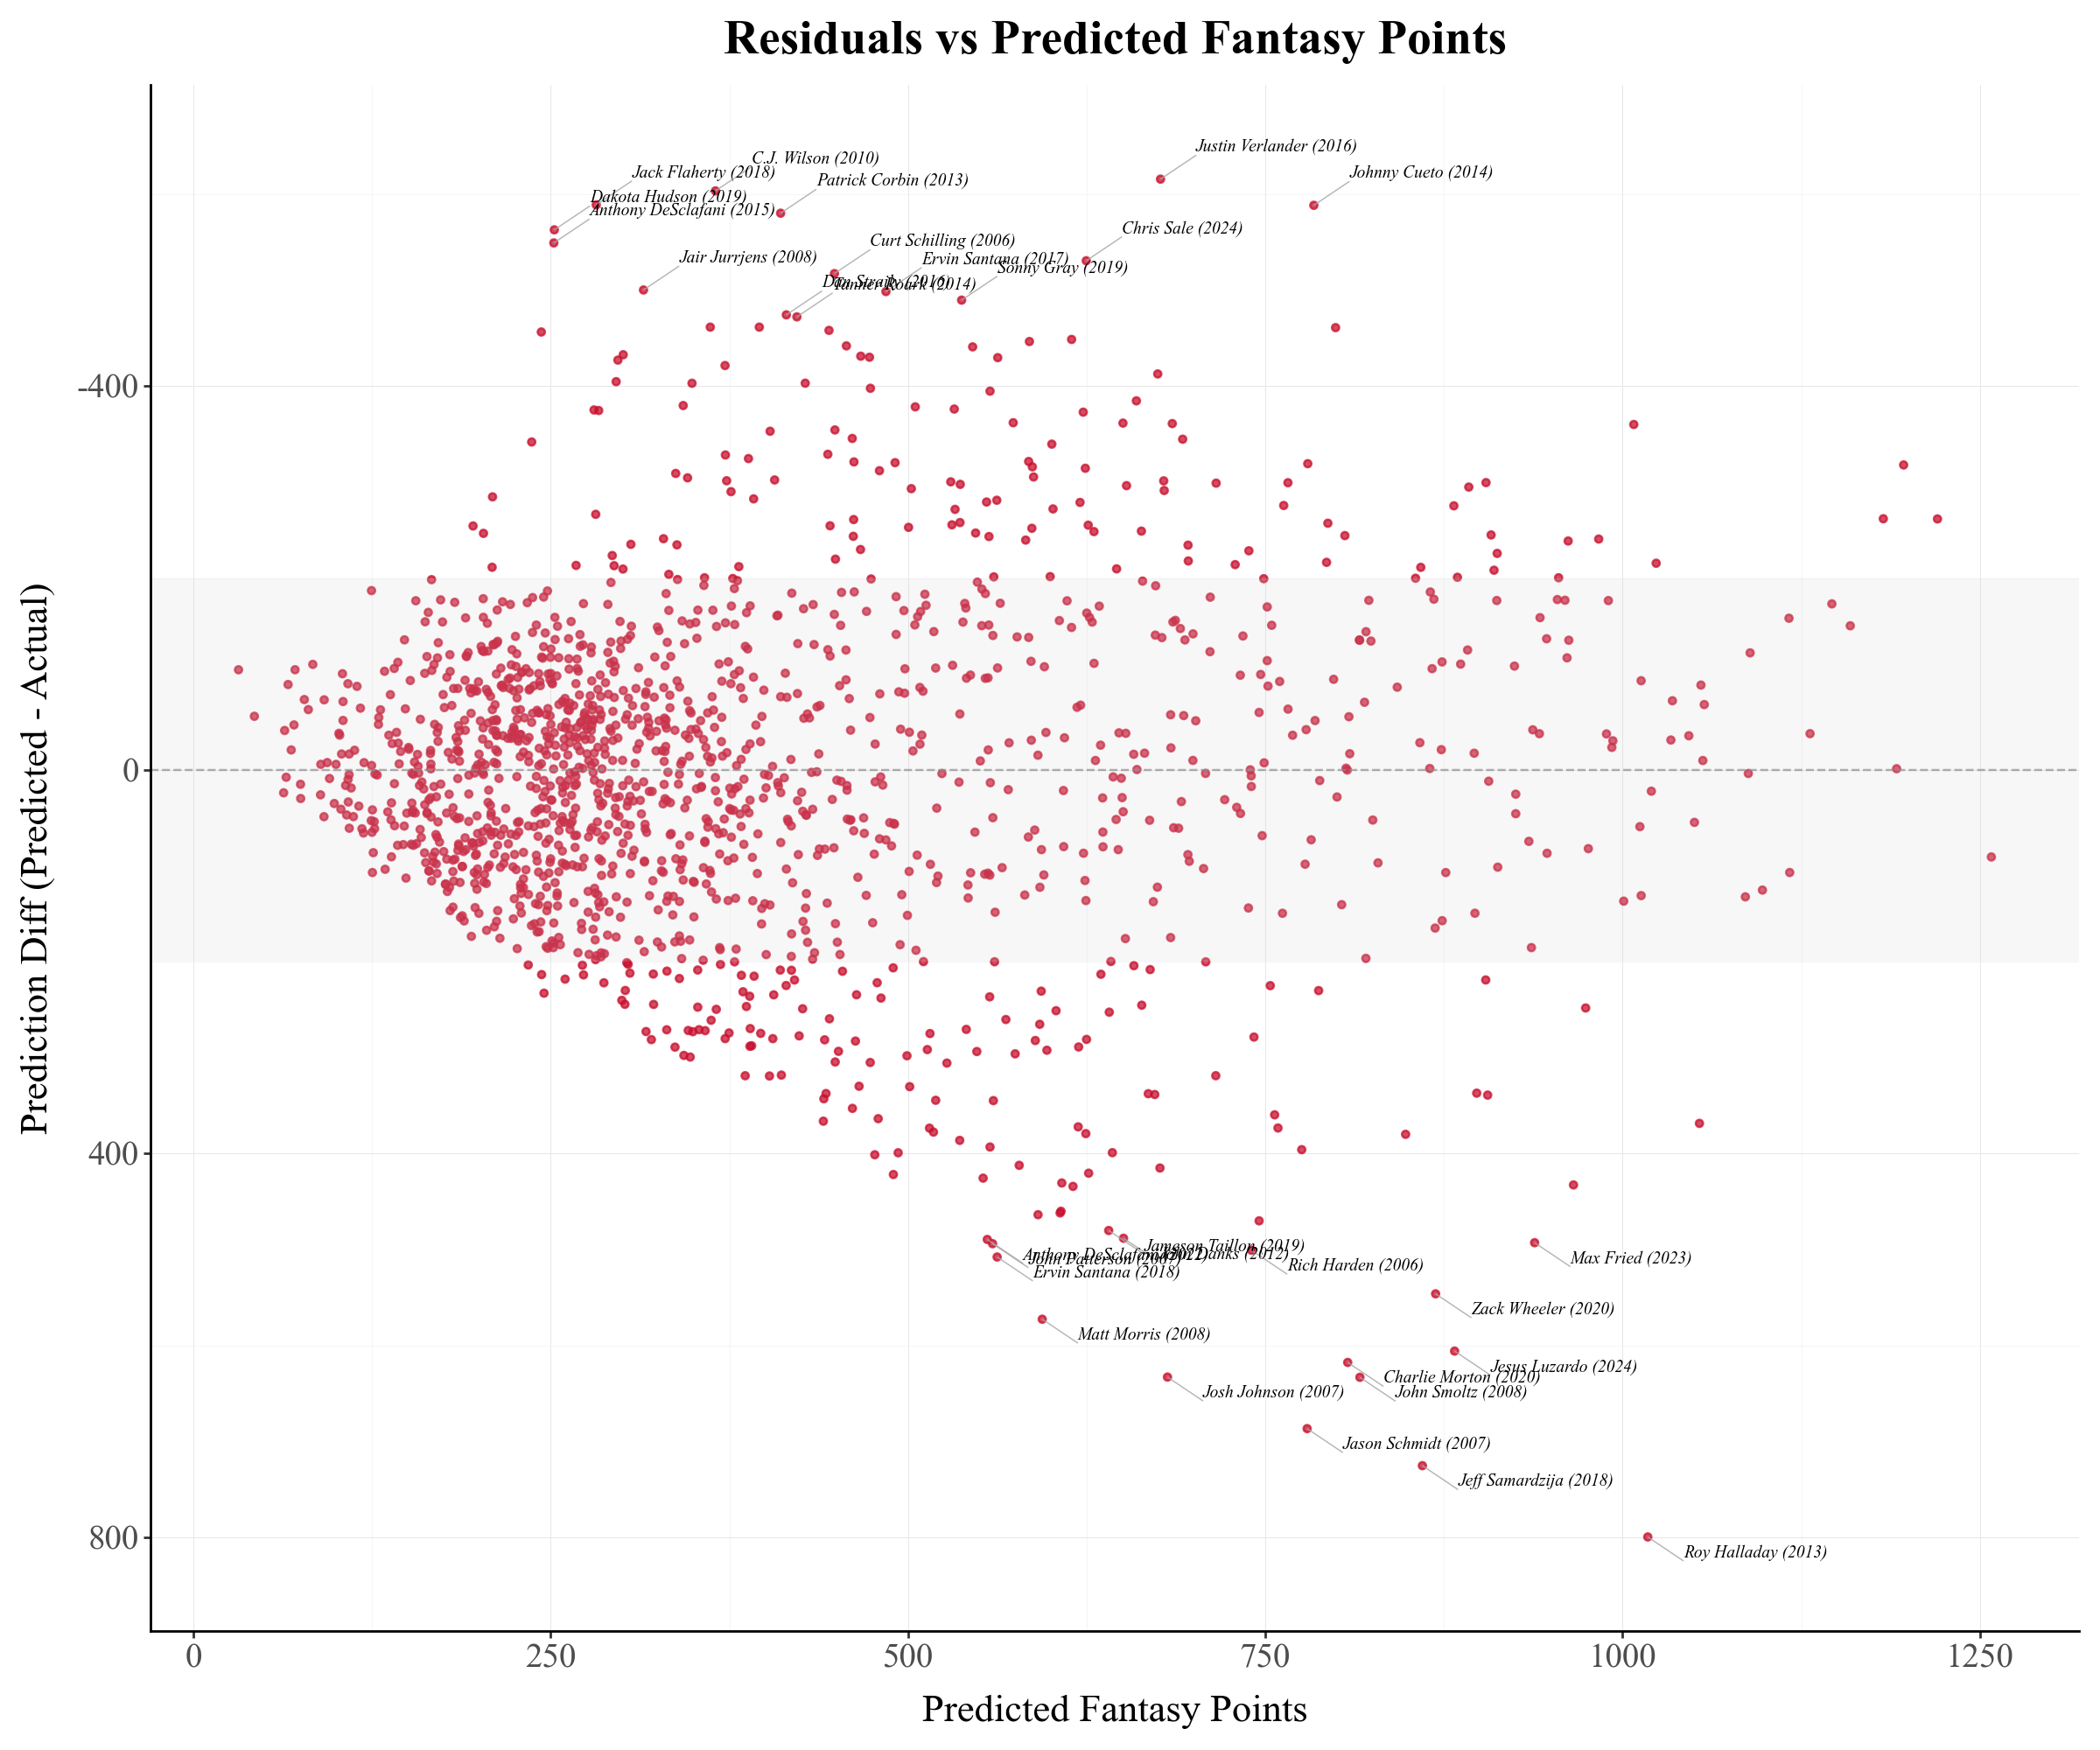

In [23]:
p2 = plot_resid_vs_pred_mlb(
    pitching_results,
    band=200,
    top_n=30,
    reverse_y=True,
    add_one_to_season_in_label=True,  # add 1 to season for labels to reflect predicted year
)
p2.show()

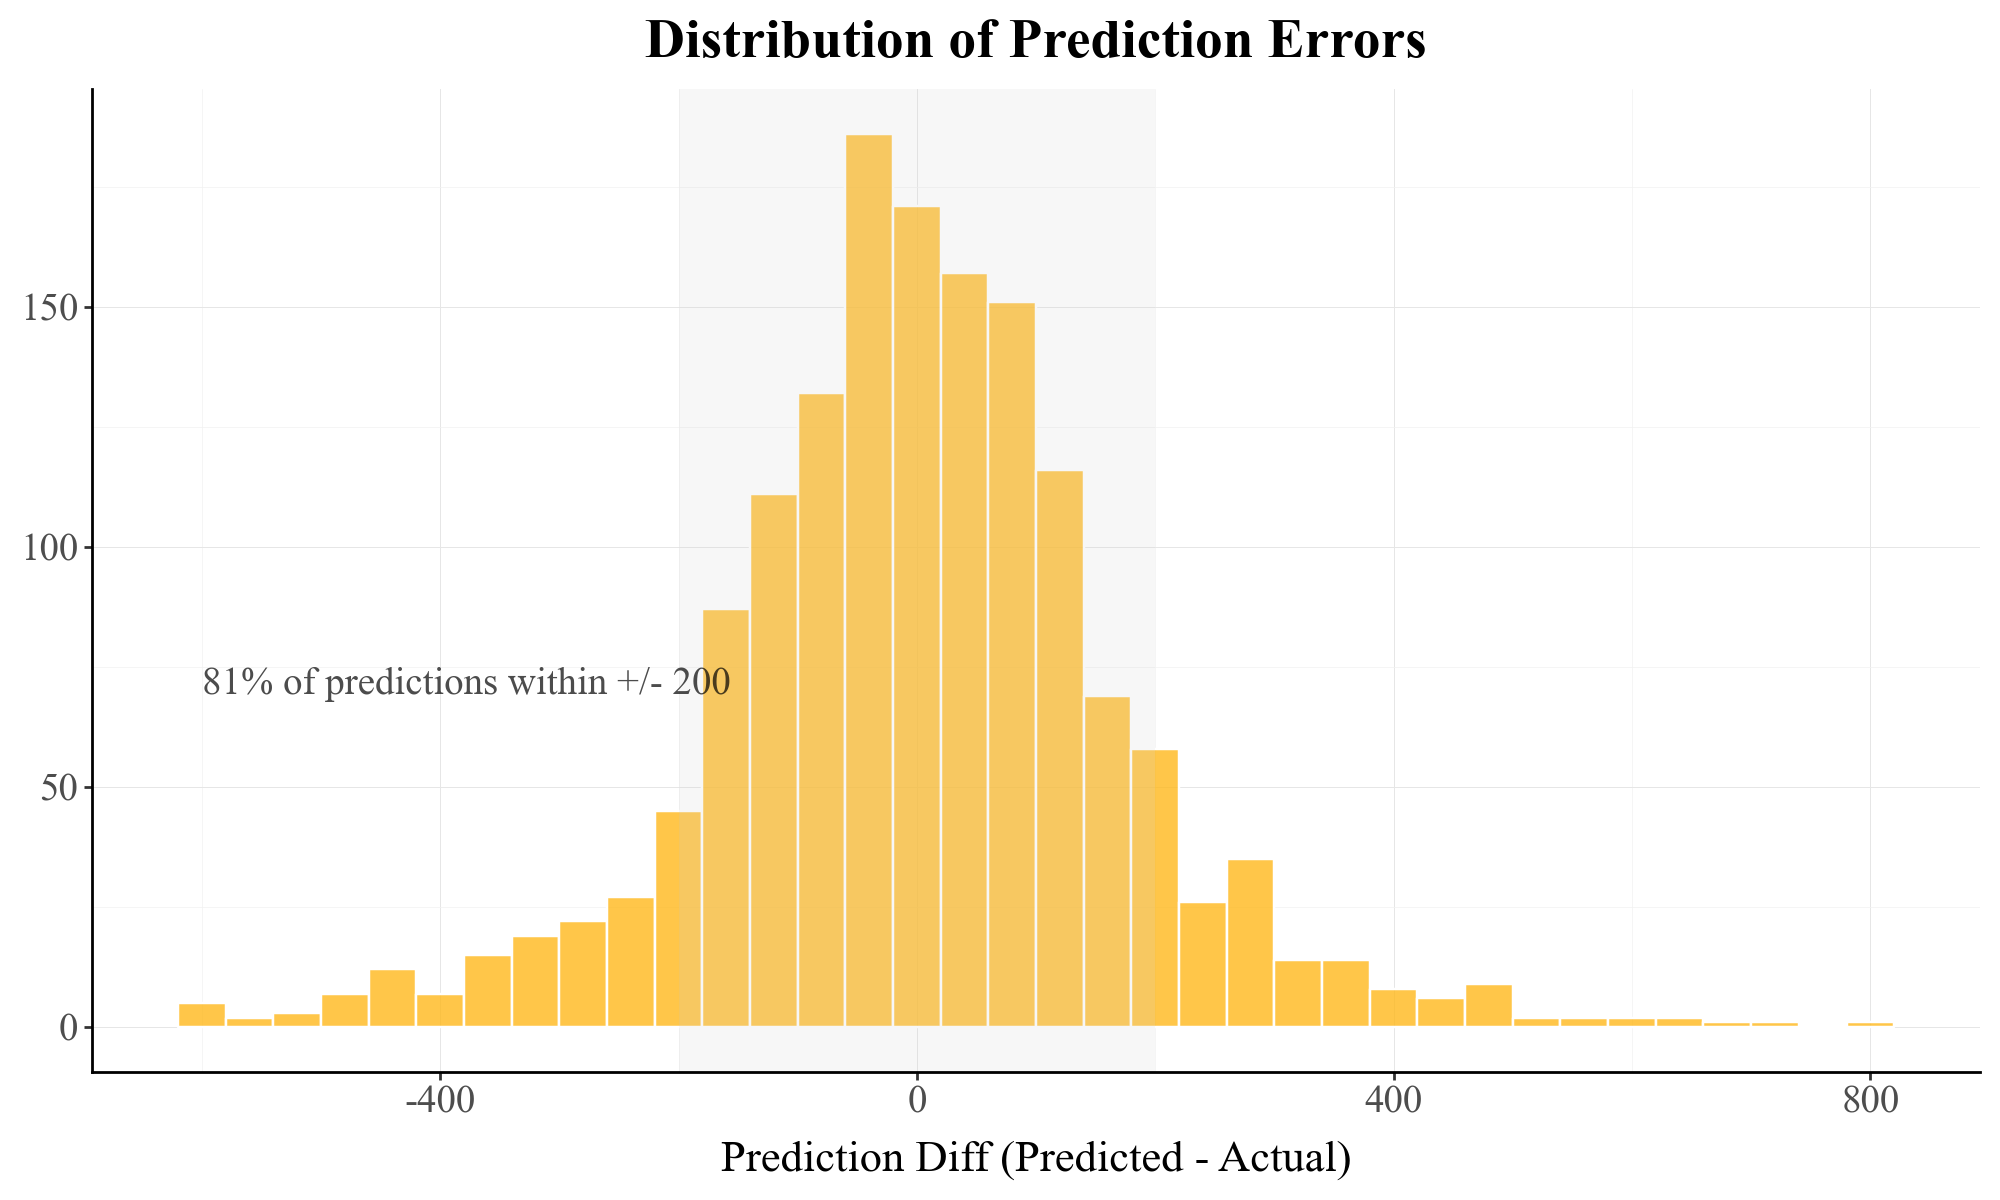

In [24]:
p3 = plot_resid_hist_mlb(
    pitching_results,
    band=200,
    binwidth=40,
    x_annotate=-600,    # custom annotation position
    y_annotate=75,      # custom annotation position
)
p3.show()

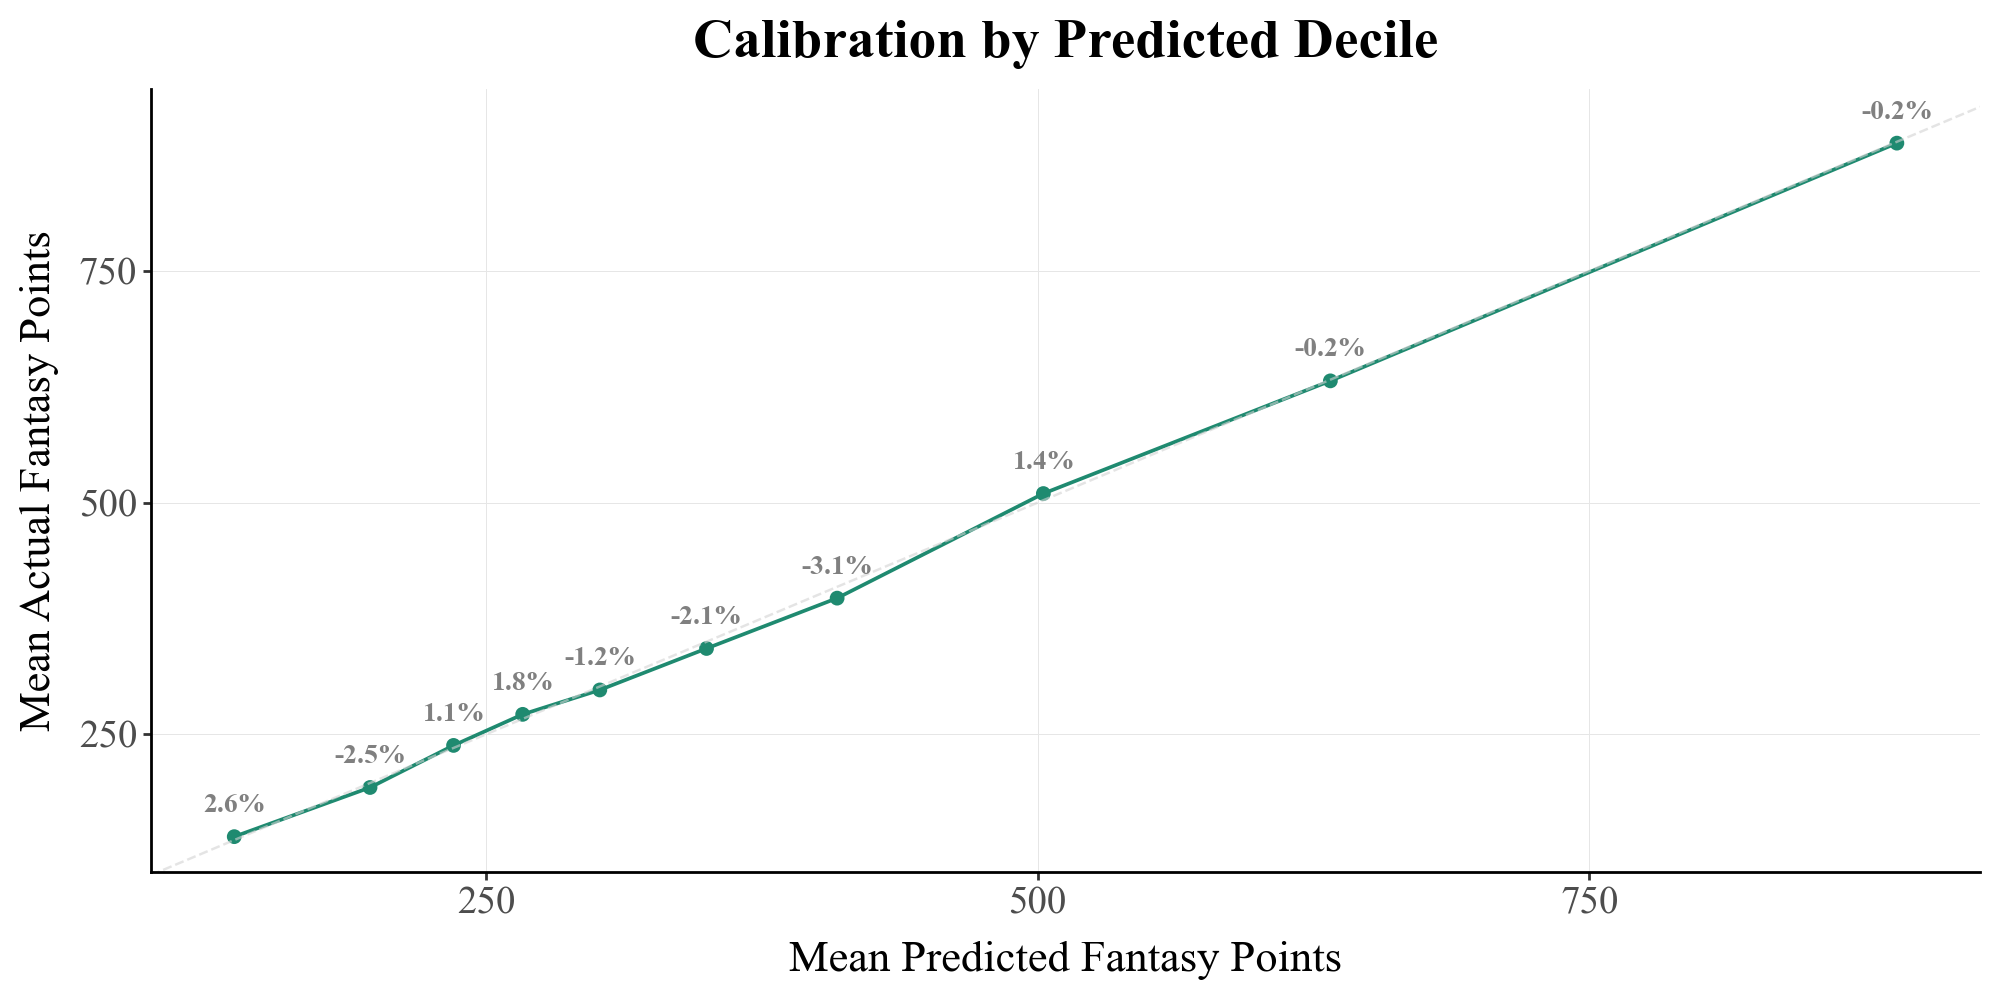

In [25]:
p4 = plot_decile_calib(pitching_results)
p4.show()

# Predicting Upcoming Season Player Performance

In [26]:
# Dropping fantasy_points_future from prediction dataframes
batting_pred = batting_pred.drop(columns=['fantasy_points_future'])
pitching_pred = pitching_pred.drop(columns=['fantasy_points_future'])

# Making predictions for the upcoming season
batting_predictions = batting_model.predict(batting_pred.drop(columns=['IDfg', 'Name']))
pitching_predictions = pitching_model.predict(pitching_pred.drop(columns=['IDfg', 'Name']))

In [27]:
batting_pred['fantasy_points_pred'] = batting_predictions
pitching_pred['fantasy_points_pred'] = pitching_predictions

batting_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)
pitching_pred.sort_values(by='fantasy_points_pred', ascending=False, inplace=True)  

In [28]:
display(batting_pred)

IDfg  Season              Name  Age    G   AB    H   1B  2B  3B  ...  \
9180   15640    2025       Aaron Judge   33  152  541  179   94  30   2  ...   
8456   13510    2025      Jose Ramirez   32  158  593  168  101  34   3  ...   
8167   12916    2025  Francisco Lindor   31  160  644  172  106  35   0  ...   
9457   16478    2025    Kyle Schwarber   32  162  604  145   64  23   2  ...   
10491  20123    2025         Juan Soto   26  160  577  152   88  20   1  ...   
...      ...     ...               ...  ...  ...  ...  ...  ...  ..  ..  ...   
10997  25434    2025       Will Wilson   26   34   78   15   11   4   0  ...   
11351  31437    2025         Jace Jung   24   21   47    5    5   0   0  ...   
11359  31562    2025      Zach Dezenzo   25   34   98   24   16   6   0  ...   
11366  31661    2025      Jacob Melton   24   32   70   11   10   0   1  ...   
11005  25483    2025       Nick Sogard   27   30   96   25   17   8   0  ...   

       G_per_year_prior3  AB_per_year_prior3  R_per_year_prior3  \
9180          138.666667               489.0         112.666667   
8456          157.333333               608.0         101.333333   
8167          157.333333          621.333333         110.666667   
9457          157.333333          587.333333         109.666667   
10491         159.666667          573.666667              115.0   
...                  ...                 ...                ...   
10997               34.0                78.0                7.0   
11351               55.0               126.0               22.0   
11359               53.0               160.0               22.0   
11366               32.0                70.0                7.0   
11005               61.0               173.0               26.0   

       H_per_year_prior3  HR_per_year_prior3  SB_per_year_prior3  \
9180          152.333333           49.333333            8.333333   
8456               171.0                31.0           37.666667   
8167          164.666667           31.666667           30.333333   
9457               134.0                47.0                 5.0   
10491              158.0           39.666667                19.0   
...                  ...                 ...                 ...   
10997               15.0                 0.0                 2.0   
11351               24.0                 0.0                 0.0   
11359               39.0                 4.0                 1.0   
11366               11.0                 0.0                 7.0   
11005               46.0                 0.0                 5.0   

       BB_per_year_prior3  SO_per_year_prior3  player_tier_recent  \
9180                115.0          153.666667                star   
8456            64.333333           76.333333                star   
8167            62.333333          131.666667                star   
9457           113.333333               203.0           above_avg   
10491          129.333333          128.333333                star   
...                   ...                 ...                 ...   
10997                 7.0                34.0         replacement   
11351                22.0                45.0         replacement   
11359                14.0                59.0         replacement   
11366                 6.0                29.0         replacement   
11005                12.0                49.0         replacement   

       fantasy_points_pred  
9180           1569.021118  
8456           1523.264404  
8167           1486.815186  
9457           1463.256348  
10491          1432.822632  
...                    ...  
10997           143.577545  
11351           141.357605  
11359           141.120987  
11366           125.360565  
11005           121.612328  

[537 rows x 217 columns]

In [29]:
display(pitching_pred)

IDfg  Season              Name  Age   G  GS  Pitches  Strikes   W  \
10615  22267    2025      Tarik Skubal   28  31  31     2849     2003  13   
9510   17995    2025        Logan Webb   28  34  34     3282     2165  15   
6616   10310    2025      Zack Wheeler   35  24  24     2394     1549  10   
7439   12768    2025        Sonny Gray   35  32  32     2724     1801  14   
10147  19959    2025     Jesus Luzardo   27  32  32     3015     1955  15   
...      ...     ...               ...  ...  ..  ..      ...      ...  ..   
11228  31612    2025  Carson Palmquist   24   9   7      705      417   0   
11226  31552    2025        Zach Agnos   24  30   0      527      309   1   
10767  24203    2025      Luis Peralta   24  22   0      436      250   1   
10943  26203    2025  Andrew Saalfrank   27  28   0      427      271   2   
11235  31701    2025     Blade Tidwell   24   4   2      309      190   1   

       WAR  ...  G_per_year_prior3  GS_per_year_prior3  IP_per_year_prior3  \
10615  6.6  ...          25.666667           25.666667          155.733333   
9510   5.5  ...          33.333333           33.333333          209.066667   
6616   4.0  ...          29.333333           29.333333               180.4   
7439   3.6  ...          30.666667           30.666667               177.0   
10147  5.3  ...          25.333333           25.333333               143.0   
...    ...  ...                ...                 ...                 ...   
11228 -0.6  ...                9.0                 7.0                34.1   
11226 -0.4  ...               30.0                 0.0                31.1   
10767 -0.7  ...               37.0                 0.0                31.1   
10943  0.5  ...          13.333333                 0.0           13.366667   
11235 -0.3  ...                4.0                 2.0                15.0   

       W_per_year_prior3  SO_per_year_prior3  BB_per_year_prior3  \
10615          12.666667          190.333333           27.333333   
9510                13.0          196.666667           42.333333   
6616                13.0          210.333333           41.333333   
7439           11.666667          195.666667                44.0   
10147           9.333333          160.666667           44.666667   
...                  ...                 ...                 ...   
11228                0.0                27.0                25.0   
11226                1.0                19.0                17.0   
10767                1.0                30.0                23.0   
10943           0.666667            8.333333                 6.0   
11235                1.0                10.0                10.0   

       HR_per_year_prior3  ER_per_year_prior3  player_tier_recent  \
10615           12.333333           41.333333                star   
9510                 15.0                77.0                star   
6616            19.666667           59.666667                star   
7439                 18.0           71.333333                star   
10147           15.666667           62.666667           above_avg   
...                   ...                 ...                 ...   
11228                10.0                34.0         replacement   
11226                 5.0                23.0         replacement   
10767                 6.0                21.0         replacement   
10943            0.333333            2.666667         replacement   
11235                 4.0                15.0         replacement   

       fantasy_points_pred  
10615           967.425354  
9510            878.215881  
6616            859.629211  
7439            834.409912  
10147           830.906433  
...                    ...  
11228            37.649006  
11226            35.214291  
10767            31.955637  
10943            29.531071  
11235            26.876760  

[590 rows x 206 columns]

In [30]:
batting_pred = split_name(batting_pred, 'Name')
pitching_pred = split_name(pitching_pred, 'Name')

In [31]:
# Creating combined batting dataframe
batting_final = combine_projections(batting_pred, batting_projections)

Duplicate rows found:


IDfg  Season       Name   Age      G     AB     H    1B    2B   3B  \
450  13301.0  2025.0  Max Muncy  34.0  100.0  313.0  76.0  45.0  10.0  2.0   
451  13301.0  2025.0  Max Muncy  34.0  100.0  313.0  76.0  45.0  10.0  2.0   
452  29779.0  2025.0  Max Muncy  22.0   63.0  206.0  44.0  28.0   7.0  0.0   
453  29779.0  2025.0  Max Muncy  22.0   63.0  206.0  44.0  28.0   7.0  0.0   

     ...  SB_per_year_prior3  BB_per_year_prior3  SO_per_year_prior3  \
450  ...                 2.0           64.666667          104.333333   
451  ...                 2.0           64.666667          104.333333   
452  ...                 1.0                10.0                68.0   
453  ...                 1.0                10.0                68.0   

     player_tier_recent  fantasy_points_pred  first_name  last_name  Team  \
450           above_avg           680.018921         max      muncy   LAD   
451           above_avg           680.018921         max      muncy   ATH   
452         replacement           331.459534         max      muncy   LAD   
453         replacement           331.459534         max      muncy   ATH   

     Positions  projected_fantasy_points  
450         3B                     879.0  
451   2B,3B,SS                     649.0  
452         3B                     879.0  
453   2B,3B,SS                     649.0  

[4 rows x 222 columns]

In [32]:
# Filter the batting_final DataFrame to drop rows where Name is "Max Muncy" and projected_fantasy_points < 750
batting_final = batting_final[~((batting_final['Name'] == 'Max Muncy') & (batting_final['projected_fantasy_points'] < 750))]

display(batting_final)

IDfg  Season            Name   Age      G     AB      H    1B    2B  \
0        NaN     NaN             NaN   NaN    NaN    NaN    NaN   NaN   NaN   
1    15640.0  2025.0     Aaron Judge  33.0  152.0  541.0  179.0  94.0  30.0   
2        NaN     NaN             NaN   NaN    NaN    NaN    NaN   NaN   NaN   
3    19844.0  2025.0    Abraham Toro  28.0   77.0  259.0   62.0  42.0  13.0   
4    27962.0  2025.0    Adael Amador  22.0   41.0  113.0   20.0  12.0   7.0   
..       ...     ...             ...   ...    ...    ...    ...   ...   ...   
683  31562.0  2025.0    Zach Dezenzo  25.0   34.0   98.0   24.0  16.0   6.0   
684  19392.0  2025.0  Zach McKinstry  30.0  144.0  452.0  117.0  71.0  23.0   
685  31347.0  2025.0       Zach Neto  24.0  128.0  502.0  129.0  73.0  29.0   
686  29766.0  2025.0      Zack Gelof  25.0   30.0   92.0   16.0  11.0   3.0   
687  19562.0  2025.0      Zack Short  30.0   22.0   50.0   11.0   7.0   2.0   

       3B  ...  SB_per_year_prior3  BB_per_year_prior3  SO_per_year_prior3  \
0     NaN  ...                <NA>                <NA>                <NA>   
1     2.0  ...            8.333333               115.0          153.666667   
2     NaN  ...                <NA>                <NA>                <NA>   
3     0.0  ...                 2.0                12.0           36.333333   
4     0.0  ...                 2.0                12.0                33.0   
..    ...  ...                 ...                 ...                 ...   
683   0.0  ...                 1.0                14.0                59.0   
684  11.0  ...                17.0                38.0           97.666667   
685   1.0  ...           20.333333           30.666667               122.0   
686   0.0  ...           13.333333           23.666667          105.333333   
687   0.0  ...            2.333333           15.333333                36.0   

     player_tier_recent  fantasy_points_pred  first_name  last_name  Team  \
0                   NaN                  NaN        a.j.   vukovich   ARI   
1                  star          1569.021118       aaron      judge   NYY   
2                   NaN                  NaN    abimelec      ortiz   TEX   
3           replacement           320.341187     abraham       toro   NaN   
4           replacement           231.950699       adael     amador   COL   
..                  ...                  ...         ...        ...   ...   
683         replacement           141.120987        zach    dezenzo   HOU   
684                 avg           748.848267        zach  mckinstry   DET   
685           above_avg          1040.558960        zach       neto   LAA   
686                 avg           413.257294        zack      gelof   ATH   
687         replacement           203.373444        zack      short   NaN   

       Positions  projected_fantasy_points  
0       3B,LF,CF                     106.0  
1    LF,CF,RF,DH                    1721.0  
2             1B                     104.0  
3            NaN                       NaN  
4             2B                     627.0  
..           ...                       ...  
683     1B,LF,RF                     173.0  
684  3B,SS,LF,RF                     734.0  
685           SS                    1308.0  
686           2B                     223.0  
687          NaN                       NaN  

[686 rows x 222 columns]

In [33]:
# Creating combined pitching dataframe
pitching_final = combine_projections(pitching_pred, pitching_projections)

No duplicate rows found.


In [34]:
# # Filter the pitching_final DataFrame to drop rows where Name is Luis Garcia and position is not RP
# pitching_final = pitching_final[~((pitching_final['Name'].isin(['Luis Garcia'])) & (pitching_final['Positions'] != 'RP'))]

display(pitching_final)

IDfg  Season            Name   Age     G    GS  Pitches  Strikes  \
0    31764.0  2025.0   A.J. Blubaugh  24.0  11.0   3.0    508.0    316.0   
1        NaN     NaN             NaN   NaN   NaN   NaN      NaN      NaN   
2        NaN     NaN             NaN   NaN   NaN   NaN      NaN      NaN   
3        NaN     NaN             NaN   NaN   NaN   NaN      NaN      NaN   
4    23550.0  2025.0     Aaron Ashby  27.0  43.0   1.0   1033.0    645.0   
..       ...     ...             ...   ...   ...   ...      ...      ...   
890  20349.0  2025.0      Zack Kelly  30.0  28.0   0.0    583.0    383.0   
891  15823.0  2025.0    Zack Littell  29.0  32.0  32.0   2789.0   1868.0   
892  10310.0  2025.0    Zack Wheeler  35.0  24.0  24.0   2394.0   1549.0   
893  25703.0  2025.0        Zak Kent  27.0  12.0   0.0    308.0    187.0   
894  31827.0  2025.0  Zebby Matthews  25.0  16.0  16.0   1353.0    895.0   

        W  WAR  ...  BB_per_year_prior3  HR_per_year_prior3  \
0     3.0  0.1  ...                11.0                 6.0   
1     NaN  NaN  ...                <NA>                <NA>   
2     NaN  NaN  ...                <NA>                <NA>   
3     NaN  NaN  ...                <NA>                <NA>   
4     5.0  1.2  ...           11.333333            1.666667   
..    ...  ...  ...                 ...                 ...   
890   1.0  0.4  ...           15.666667            4.333333   
891  10.0  1.5  ...                25.0           23.666667   
892  10.0  4.0  ...           41.333333           19.666667   
893   1.0  0.1  ...                 8.0                 1.0   
894   5.0  1.4  ...                17.5                11.5   

     ER_per_year_prior3  player_tier_recent  fantasy_points_pred  first_name  \
0                   6.0         replacement           231.320435        a.j.   
1                  <NA>                 NaN                  NaN        a.j.   
2                  <NA>                 NaN                  NaN        a.j.   
3                  <NA>                 NaN                  NaN        a.j.   
4              8.333333         replacement           357.519318       aaron   
..                  ...                 ...                  ...         ...   
890           15.666667         replacement           193.073410        zack   
891                61.0                 avg           427.258759        zack   
892           59.666667                star           859.629211        zack   
893                 9.0         replacement            86.935532         zak   
894                38.5         replacement           326.040619       zebby   

     last_name  Team  Positions  projected_fantasy_points  
0     blubaugh   NaN        NaN                       NaN  
1       causey    KC          P                      83.0  
2       minter   NYM         RP                     294.3  
3          puk   ARI         RP                     159.1  
4        ashby   MIL         RP                     300.6  
..         ...   ...        ...                       ...  
890      kelly   BOS      SP,RP                     241.2  
891    littell   NaN         SP                     709.4  
892    wheeler   PHI         SP                     723.9  
893       kent   TEX      SP,RP                     202.6  
894   matthews   MIN         SP                     585.5  

[895 rows x 211 columns]

In [35]:
# Suppress the SettingWithCopyWarning while updating player names
pd.options.mode.chained_assignment = None  # default='warn'

In [36]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
batting_final['Name'] = batting_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
batting_final = batting_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "DH" for hitters
batting_final['Positions'] = batting_final['Positions'].fillna('DH')

# Taking the first value in the Positions column as the player's primary position
batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

# Replacing LF, CF, and RF positions with "OF" for alignment with standard rankings
batting_final['Positions'] = batting_final['Positions'].replace({'LF': 'OF', 'CF': 'OF', 'RF': 'OF'})

# Renaming Positions to Position
batting_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [37]:
# Replace NaN values in the Name column with concatenation of first_name and last_name with first letters capitalized
pitching_final['Name'] = pitching_final.apply(
    lambda row: row['first_name'].capitalize() + ' ' + row['last_name'].capitalize() if pd.isna(row['Name']) else row['Name'],
    axis=1
)

# Selecting final relevant columns for predictions
pitching_final = pitching_final[['IDfg', 'Name', 'Age', 'Team', 'Positions', 'fantasy_points_pred', 'projected_fantasy_points']]

# Replace NaN values in the "Positions" column with "SP" for pitchers
pitching_final['Positions'] = pitching_final['Positions'].fillna('SP')

# Taking the first value in the Positions column as the player's primary position
pitching_final['Positions'] = pitching_final['Positions'].apply(get_value_before_comma)

# Renaming Positions to Position
pitching_final.rename(columns={'Positions': 'Position'}, inplace=True)

In [38]:
# def get_value_before_comma(value):
#     if ',' in value:
#         return value.split(',')[0]
#     return value

# # Apply the function to the column
# batting_final['Positions'] = batting_final['Positions'].apply(get_value_before_comma)

In [39]:
# Display the DataFrame to verify the changes
display(batting_final)

IDfg            Name   Age Team Position  fantasy_points_pred  \
0        NaN   A.j. Vukovich   NaN  ARI       3B                  NaN   
1    15640.0     Aaron Judge  33.0  NYY       OF          1569.021118   
2        NaN  Abimelec Ortiz   NaN  TEX       1B                  NaN   
3    19844.0    Abraham Toro  28.0  NaN       DH           320.341187   
4    27962.0    Adael Amador  22.0  COL       2B           231.950699   
..       ...             ...   ...  ...      ...                  ...   
683  31562.0    Zach Dezenzo  25.0  HOU       1B           141.120987   
684  19392.0  Zach McKinstry  30.0  DET       3B           748.848267   
685  31347.0       Zach Neto  24.0  LAA       SS          1040.558960   
686  29766.0      Zack Gelof  25.0  ATH       2B           413.257294   
687  19562.0      Zack Short  30.0  NaN       DH           203.373444   

     projected_fantasy_points  
0                       106.0  
1                      1721.0  
2                       104.0  
3                         NaN  
4                       627.0  
..                        ...  
683                     173.0  
684                     734.0  
685                    1308.0  
686                     223.0  
687                       NaN  

[686 rows x 7 columns]

In [40]:
# Display the DataFrame to verify the changes
display(pitching_final)

IDfg            Name   Age Team Position  fantasy_points_pred  \
0    31764.0   A.J. Blubaugh  24.0  NaN       SP           231.320435   
1        NaN     A.j. Causey   NaN   KC        P                  NaN   
2        NaN     A.j. Minter   NaN  NYM       RP                  NaN   
3        NaN        A.j. Puk   NaN  ARI       RP                  NaN   
4    23550.0     Aaron Ashby  27.0  MIL       RP           357.519318   
..       ...             ...   ...  ...      ...                  ...   
890  20349.0      Zack Kelly  30.0  BOS       SP           193.073410   
891  15823.0    Zack Littell  29.0  NaN       SP           427.258759   
892  10310.0    Zack Wheeler  35.0  PHI       SP           859.629211   
893  25703.0        Zak Kent  27.0  TEX       SP            86.935532   
894  31827.0  Zebby Matthews  25.0  MIN       SP           326.040619   

     projected_fantasy_points  
0                         NaN  
1                        83.0  
2                       294.3  
3                       159.1  
4                       300.6  
..                        ...  
890                     241.2  
891                     709.4  
892                     723.9  
893                     202.6  
894                     585.5  

[895 rows x 7 columns]

# Finalizing Predictions & Creating Relative Positional Value Scores

In [41]:
# Replace NULL values in the prediction column with values from the projected column and vice versa
batting_final['fantasy_points_pred'] = batting_final['fantasy_points_pred'].fillna(batting_final['projected_fantasy_points'])
batting_final['projected_fantasy_points'] = batting_final['projected_fantasy_points'].fillna(batting_final['fantasy_points_pred'])

pitching_final['fantasy_points_pred'] = pitching_final['fantasy_points_pred'].fillna(pitching_final['projected_fantasy_points'])
pitching_final['projected_fantasy_points'] = pitching_final['projected_fantasy_points'].fillna(pitching_final['fantasy_points_pred'])

In [42]:
# Splitting batting players into infielders and outfielders
batting_final_if = batting_final[batting_final['Position'] != 'OF']
batting_final_of = batting_final[batting_final['Position'] == 'OF']

In [43]:
# Creating final projected score, with 70% weight being placed on predictions and 30% weight being placed on fantasypros projections
# Creating initial player rankings based on final projection
batting_final_if['final_projection'] = (batting_final_if['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_if['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_if['initial_rank'] = batting_final_if['final_projection'].rank(ascending=False)

batting_final_of['final_projection'] = (batting_final_of['fantasy_points_pred'] * MODEL_WEIGHT) + (batting_final_of['projected_fantasy_points'] * PROJECTION_WEIGHT)
batting_final_of['initial_rank'] = batting_final_of['final_projection'].rank(ascending=False)

pitching_final['final_projection'] = (pitching_final['fantasy_points_pred'] * MODEL_WEIGHT) + (pitching_final['projected_fantasy_points'] * PROJECTION_WEIGHT)
pitching_final['initial_rank'] = pitching_final['final_projection'].rank(ascending=False)

In [44]:
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
pitcher_pool = round(player_pool * PITCHER_SPLIT, 0)
batter_pool_if = round(player_pool * BATTER_SPLIT_IF, 0)
batter_pool_of = round(player_pool * BATTER_SPLIT_OF, 0)

In [45]:
# Using player pool cutoffs to filter batting and pitching draft pool
batting_final_if = batting_final_if[batting_final_if['initial_rank'] <= batter_pool_if]
batting_final_of = batting_final_of[batting_final_of['initial_rank'] <= batter_pool_of]
pitching_final = pitching_final[pitching_final['initial_rank'] <= pitcher_pool]

In [46]:
batting_final = pd.concat([batting_final_if, batting_final_of])

In [55]:
# Adjusting positional group for select players within the batting_final dataframe to align with 2026 position designations
batting_final.loc[batting_final['Name'] == 'Shohei Ohtani', 'Position'] = 'OF'
batting_final.loc[batting_final['Name'] == 'Rafael Devers', 'Position'] = 'OF'
batting_final.loc[batting_final['Name'] == 'Tyler Soderstrom', 'Position'] = 'OF'

batting_final = assign_position_group(batting_final, position_col = 'Position')

pitching_final = assign_position_group(pitching_final, position_col = 'Position')

In [56]:
# Combine dataframes into a complete dataframe containing batters and hitters
combined_df = pd.concat([batting_final, pitching_final])

In [57]:
# Calculating relative positional values & ranking players within position based on projected value
value_df = calculate_relative_value(
    df=combined_df,
    position_col="position_group",
    projection_col="final_projection",
    vorp_cutoff=0.7,
    vorp_scale=1, # VORP scale set to 1, see validation within "estimate_vorp_scale.ipynb"
    dampening_map=POS_DAMPENING_MAP,
)

In [58]:
# Saving value_df to CSV for vorp_scale estimation
# value_df.to_csv('notebooks/value_df.csv', index=False)

# Create Player Value Segments

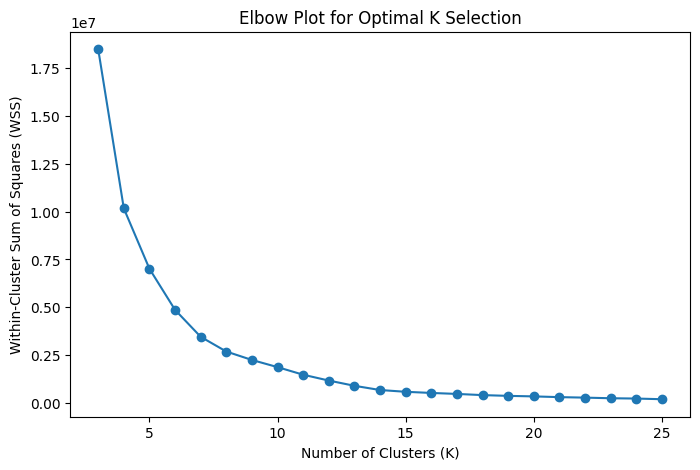

In [59]:
# Evaluating clustering performance on varying K values
determine_optimal_k(value_df, max_k = 25)

In [60]:
# Setting a K of 18 and placing players into relative value tiers
final_df = segment_players(value_df, k = 18)

In [61]:
# Sorting final dataframe based on relative value, player value tier & position rank
final_df = final_df.sort_values(by = ['relative_value', 'player_value_tier', 'position_rank'], ascending = False)

# Selecting final columns for output
final_df = final_df[['Name', 'Age', 'Team', 'Position', 'position_group', 'fantasy_points_pred', 'projected_fantasy_points', 
                     'final_projection', 'relative_value', 'overall_ranking', 'position_rank', 'player_value_tier']]

In [62]:
final_df.to_csv(f'data/predictions_{datetime.now().strftime('%Y-%m-%d')}.csv', index=False)